## License
This file is part of the project megFingerprinting. All of megFingerprinting code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. megFingerprinting is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with megFingerprinting. If not, see https://www.gnu.org/licenses/.

In [228]:
import difflib
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import seaborn as sns
import scipy as sp
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
sns.set()
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", 8))

# I. Subject Identifiability: Original Feature Space vs PCA Reconstructed

In [17]:
# Parameters
n_subs = 112 # Change here to get number of participants! 
n_feats = int(68*69/2)

In [18]:
# Warangle data set into two big feature matrices
def prune_subject_csv(filename):
    '''
    This function takes in the subject's csv file from MATLAB, takes out the 
    doubled correlations (because of symmetry) and outputs a numpy array ready to be concatenated
    in the grand feature matrix
    Args:
        filename (string): Name of the csv matrix
    Returns: 
        sub_feat (np.array): Subject's features 
    '''
    n_feats = int(68*69/2)
    freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
    sub_feat = np.zeros([1, (n_feats*6)+1]) # Number of unique values in corr matrix + subject label
    x = 0
    for i_freq in range(len(freq_band)):
        aec_matrix = pd.read_csv(filename, names = ['source', 'target', 'corr', 'freq_band'])
        aec_matrix = aec_matrix.loc[aec_matrix['freq_band'] == freq_band[i_freq]]
        aec_matrix = aec_matrix.replace('\s', '', regex = True).pivot_table(index = 'source', columns = 'target', values = 'corr') 
        df_out = aec_matrix.stack()
        df_out = df_out[df_out.index.get_level_values(0) <= df_out.index.get_level_values(1)] # Gets rid of symmetrical correlations
        df_out.index = df_out.index.map('_'.join)
        sub_feat[0, i_freq*n_feats : ((i_freq+1)*n_feats)] = df_out.to_frame().T.values
        x += 1
    sub_feat[0, -1] = int(filename[25:28])    
    return sub_feat

# Get n subjects: both training and testing datasets
onlyfiles = [f for f in listdir('output/csv_matrices/') if isfile(join('output/csv_matrices/', f))]
sub_target = np.zeros([n_subs, (n_feats*6)+1])
sub_database = np.zeros([n_subs, (n_feats*6)+1])
iv = 0
it = 0
for iFile in sorted(onlyfiles)[0:(n_subs*2)]: 
    sub = 'output/csv_matrices/' + iFile
    if sub[39] == 'v':
        sub_target[iv, :] = prune_subject_csv(sub)
        iv += 1
    else:
        sub_database[it, :] = prune_subject_csv(sub)
        it += 1

In [19]:
# Correlations can be computed as the dot product between two z-scored vectors
z_target = sp.stats.zscore(sub_target[:, :-1], axis = 1)
z_database = sp.stats.zscore(sub_database[:,:-1], axis = 1)
predictions = z_target.dot(z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
target_from_database = accuracy_score(range(n_subs), predictions.argmax(axis = 1))
database_from_target = accuracy_score(range(n_subs), predictions.argmax(axis = 0))

print('When predicting the target from the database, we get a ' + str(target_from_database*100)[0:5] + '% accuracy')
print('When predicting the database from the target, we get a ' + str(database_from_target*100)[0:5] + '% accuracy')

When predicting the target from the database, we get a 94.64% accuracy
When predicting the database from the target, we get a 93.75% accuracy


## We get pretty high raw accuracy scores (similar to what Finn et al., 2015). No we look at the influence of using a PCA reconstruction (i.e. the framework Amico & Goñi suggested) on the feature space

In [220]:
# Take feature matrix of each subject and put it in one, big matrix (n_subs * 2, features)
fc = np.concatenate((sub_target[:, :-1], sub_database[:, :-1]), axis = 0)
labels = np.concatenate((sub_target[:, -1], sub_database[:, -1]), axis = 0)
steps = np.concatenate((np.array([2, 5]), np.arange(10, (n_subs*2) ,10)), axis = 0) # 2, 5, 10 - n_subs*2 in 10 
pca_target_from_database = np.zeros(len(steps))
pca_database_from_target = np.zeros(len(steps))
pca_self_id = np.zeros((len(steps), n_subs))
# Get the PCA decomposition in an iterative manner and calculate raw accuracy at each step of the way 
for i in range(len(steps)):
    # PCA reconstruction usin i components
    pca = PCA(n_components = steps[i]) 
    pca.fit(fc) # Estimate the components (using an SVD on the centered fc)
    fc_pca = pca.transform(fc) # Calculate the loadings
    fc_recon = pca.inverse_transform(fc_pca) # Get projection onto components in signal space and add back means
    
    # Accuracy and self-identifiability
    pca_sub_target = fc_recon[:n_subs, :]
    pca_sub_database = fc_recon[n_subs:, :]
    pca_z_target = sp.stats.zscore(pca_sub_target, axis = 1)
    pca_z_database = sp.stats.zscore(pca_sub_database, axis = 1)
    pca_predictions = pca_z_target.dot(pca_z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
    pca_target_from_database[i] = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 1))
    pca_database_from_target[i] = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 0))
    pca_self_id[i, :] = np.diagonal(sp.stats.zscore(pca_predictions, axis = 1))
    
# For the figure, we also get self-identifiability and reconstructed self-identifiability
self_id = np.diagonal(sp.stats.zscore(predictions, axis = 1))

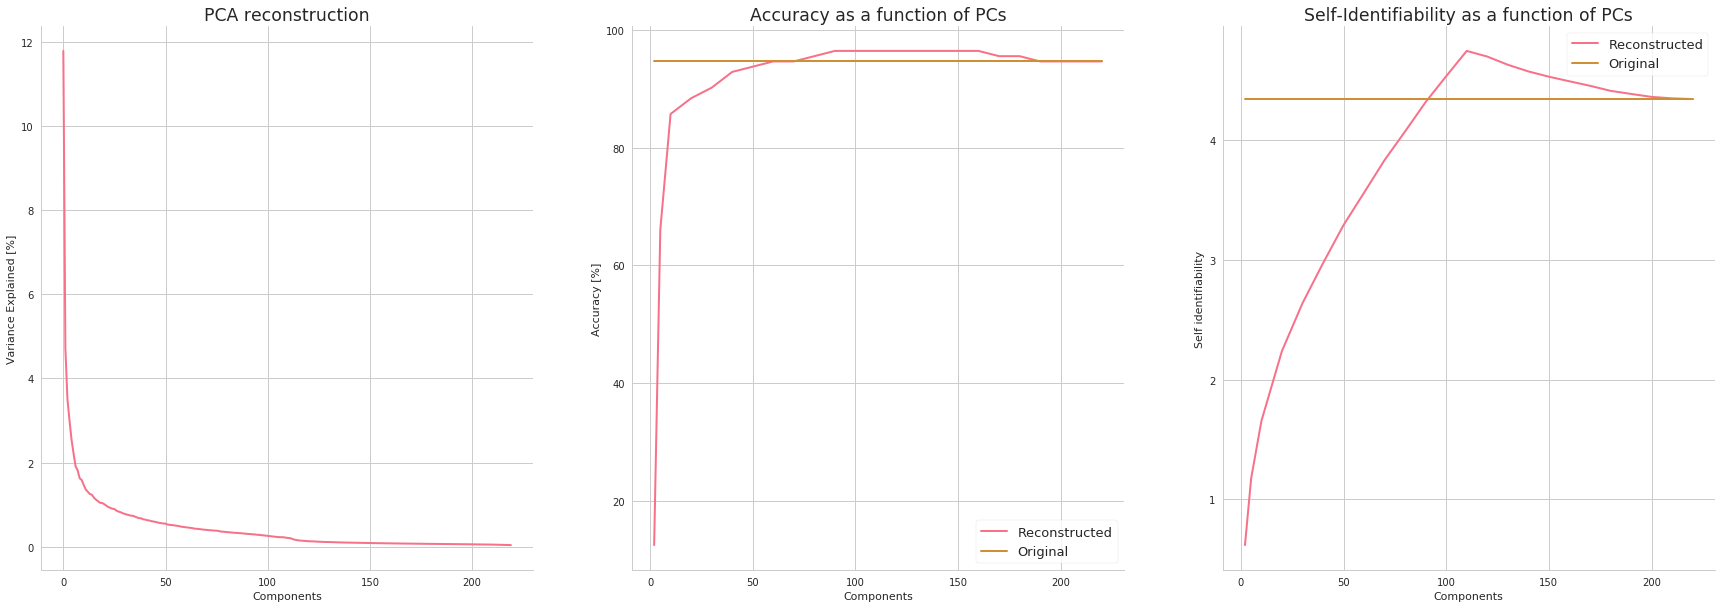

In [229]:
# Get the fig initiated
fig, axs = plt.subplots(1,3, figsize=(30, 10))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Variance explained vs Components
axs[0].plot(pca.explained_variance_ratio_*100, linewidth=2)
axs[0].set_xlabel('Components')
axs[0].set_ylabel('Variance Explained [%]')
axs[0].set_title('PCA reconstruction', size = 'x-large')

# Accuracy vs Components
axs[1].plot(steps, pca_target_from_database*100, linewidth = 2, label = 'Reconstructed')
axs[1].plot(steps, target_from_database.repeat(len(steps))*100, linewidth = 2, label = 'Original')
axs[1].set_xlabel('Components')
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_title('Accuracy as a function of PCs', size = 'x-large')
axs[1].legend(fontsize = 13, frameon = True)

# Self identifiability vs Components
axs[2].plot(steps, pca_self_id.mean(axis = 1), linewidth = 2, label = 'Reconstructed')
axs[2].plot(steps, self_id.mean().repeat(len(steps)), linewidth = 2, label = 'Original')
axs[2].set_xlabel('Components')
axs[2].set_ylabel('Self identifiability')
axs[2].set_title('Self-Identifiability as a function of PCs', size = 'x-large')
axs[2].legend(fontsize = 13, frameon = True)

sns.despine()
plt.show()

In [287]:
# Get the PCA reconstruction from the number of components that give us the max self_identifiability 
pca = PCA(n_components = steps[np.argmax(pca_self_id.mean(axis = 1))]) 
pca.fit(fc) # Estimate the components (using an SVD on the centered fc)
fc_pca = pca.transform(fc) # Calculate the loadings
fc_recon = pca.inverse_transform(fc_pca) # Get projection onto components in signal space

# Accuracy and self-identifiability
pca_sub_target = fc_recon[:n_subs, :]
pca_sub_database = fc_recon[n_subs:, :]
pca_z_target = sp.stats.zscore(pca_sub_target, axis = 1)
pca_z_database = sp.stats.zscore(pca_sub_database, axis = 1)
pca_predictions = pca_z_target.dot(pca_z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
pca_target_from_database = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 1))
pca_database_from_target = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 0))
pca_self_id = np.diagonal(sp.stats.zscore(pca_predictions, axis = 1))

print('When predicting the reconstructed target from the reconstructed database, we get a ' + str(pca_target_from_database) + ' accuracy')
print('When predicting the reconstructed database from the reconstructed target, we get a ' + str(pca_database_from_target) + ' accuracy')

When predicting the reconstructed target from the reconstructed database, we get a 0.9642857142857143 accuracy
When predicting the reconstructed database from the reconstructed target, we get a 0.9553571428571429 accuracy


/home/labuser/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


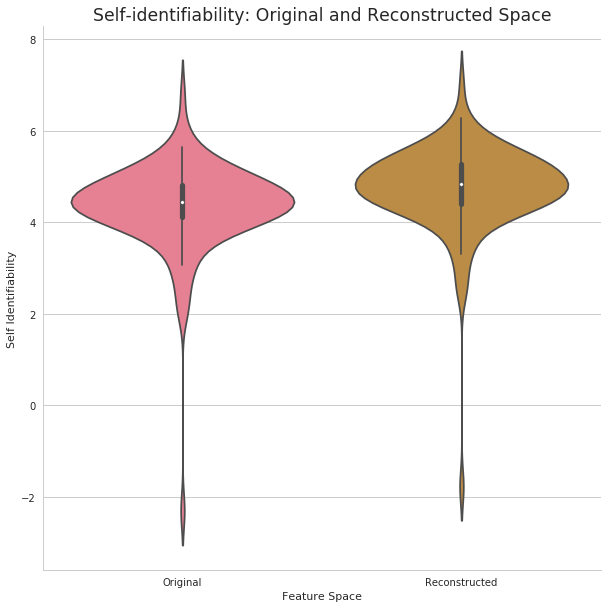

In [29]:
vp_original = np.concatenate((np.expand_dims(self_id, axis = 1), np.expand_dims(np.repeat('Original', n_subs), axis = 1)), axis = 1)
vp_recon = np.concatenate((np.expand_dims(pca_self_id, axis = 1), np.expand_dims(np.repeat('Reconstructed', n_subs), axis = 1)), axis = 1)
self_id_grand = np.concatenate((vp_original, vp_recon), axis = 0)
self_id_plot = pd.DataFrame(data = self_id_grand, columns = ['Self Identifiability', 'Feature Space'])
self_id_plot['Self Identifiability'] = self_id_plot['Self Identifiability'].astype(float)
self_id_plot['Feature Space'] = self_id_plot['Feature Space'].astype('category', ordered = False, categories = ['Original', 'Reconstructed'])

plt.figure(figsize=(10, 10))
axs = sns.violinplot(x = 'Feature Space', y = 'Self Identifiability', data = self_id_plot)
axs.set_title('Self-identifiability: Original and Reconstructed Space', size = 'x-large')
sns.despine()
plt.show()

# II. Edgewise contributions to identifiability

## Now that we know subjects are highly identifiable, we ask the question: what edges are driving this? Are there edges that are more important than others? To do so, we compare three measurements: differential power and group consistency (Finn et al., 2015) and interclass correlation coefficient

## We start with differential power with both the reconstructed and the original data

In [30]:
differential_power = np.zeros(z_target.shape[1])
pca_differential_power = np.zeros(pca_z_target.shape[1])
for iEdge in range(z_target.shape[1]):
    p_e = np.zeros(n_subs)
    pca_p_e = np.zeros(n_subs)
    for iSubject in range(n_subs):
        # Original
        rho_ii = z_target[iSubject, iEdge] * z_database[iSubject, iEdge] #subjects to itself; the higher, the more consistent across target and database measurements
        rho_ij = z_target[iSubject, iEdge] * z_database[np.arange(n_subs)!= iSubject, iEdge]
        rho_ji = z_database[iSubject, iEdge] * z_target[np.arange(n_subs)!= iSubject, iEdge]
        prob_ij = (rho_ij > rho_ii).astype(float)
        prob_ji = (rho_ji > rho_ii).astype(float)
        p_e[iSubject] = (prob_ij.sum() + prob_ji.sum())/(2.*(n_subs - 1))
        if p_e[iSubject] == 0:
            p_e[iSubject] = 1/(2.*(n_subs - 1))
        
        # Reconstructed
        pca_rho_ii = pca_z_target[iSubject, iEdge] * pca_z_database[iSubject, iEdge] #subjects to itself; the higher, the more consistent across target and database measurements
        pca_rho_ij = pca_z_target[iSubject, iEdge] * pca_z_database[np.arange(n_subs)!= iSubject, iEdge]
        pca_rho_ji = pca_z_database[iSubject, iEdge] * pca_z_target[np.arange(n_subs)!= iSubject, iEdge]  
        pca_prob_ij = (pca_rho_ij > pca_rho_ii).astype(float)
        pca_prob_ji = (pca_rho_ji > pca_rho_ii).astype(float)
        pca_p_e[iSubject] = (pca_prob_ij.sum() + pca_prob_ji.sum())/(2.*(n_subs - 1))
        if pca_p_e[iSubject] == 0:
            pca_p_e[iSubject] = 1/(2.*(n_subs - 1))
            
    differential_power[iEdge] = (-1 * np.log(p_e)).sum() 
    pca_differential_power[iEdge] = (-1 * np.log(pca_p_e)).sum() 
    
min_dp = np.min(differential_power)
max_dp = np.max(differential_power)
pca_min_dp = np.min(pca_differential_power)
pca_max_dp = np.max(pca_differential_power)
print(min_dp)
print(max_dp)
print(pca_min_dp)
print(pca_max_dp)

86.68284868759736
186.3110031813106
95.4190538339871
188.8289985198778


In [31]:
# We prepare the dataframe for the plotting 
# We start getting the labels from an arbitrary csv matrix
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
aec_matrix_l = pd.read_csv(sub, names = ['source', 'target', 'corr', 'freq_band']) # Get labels
aec_matrix_l = aec_matrix_l.loc[aec_matrix_l['freq_band'] == 'delta']
aec_matrix_l = aec_matrix_l.replace('\s', '', regex = True).pivot_table(index = 'source', columns = 'target', values = 'corr') 
df_out = aec_matrix_l.stack()
df_out = df_out[df_out.index.get_level_values(0) <= df_out.index.get_level_values(1)]
df_out.index = df_out.index.map('_'.join)
temp_labels = list(df_out.index)
labels = list(map(( lambda x: x + '_delta'), temp_labels)) + list(map(( lambda x: x + '_theta'), temp_labels)) + list(map(( lambda x: x + '_alpha'), temp_labels)) +\
         list(map(( lambda x: x + '_beta'), temp_labels)) + list(map(( lambda x: x + '_gamma'), temp_labels)) + list(map(( lambda x: x + '_hgamma'), temp_labels))

# Original
dp_df = pd.DataFrame(data = np.array([labels, differential_power], dtype=object).transpose(), 
                     columns = ['labels', 'differential_power'])
dp_df['differential_power'] = dp_df['differential_power'].astype(float)
dp_df['str_split'] = dp_df['labels'].str.split('_')
dp_df['source'] = dp_df.str_split.str.get(0)
dp_df['target'] = dp_df.str_split.str.get(1)
dp_df['freq'] = dp_df.str_split.str.get(2)
dp_df.loc[:, 'rsn_srce'] = 'temp'
dp_df.loc[:, 'rsn_trgt'] = 'temp'
dp_df = dp_df.drop(['labels', 'str_split'], axis = 1)

# PCA
pca_dp_df = pd.DataFrame(data = np.array([labels, pca_differential_power], dtype=object).transpose(), 
                     columns = ['labels', 'pca_differential_power'])
pca_dp_df['pca_differential_power'] = pca_dp_df['pca_differential_power'].astype(float)
pca_dp_df['str_split'] = pca_dp_df['labels'].str.split('_')
pca_dp_df['source'] = pca_dp_df.str_split.str.get(0)
pca_dp_df['target'] = pca_dp_df.str_split.str.get(1)
pca_dp_df['freq'] = pca_dp_df.str_split.str.get(2)
pca_dp_df.loc[:, 'rsn_srce'] = 'temp'
pca_dp_df.loc[:, 'rsn_trgt'] = 'temp'
pca_dp_df = pca_dp_df.drop(['labels', 'str_split'], axis = 1)

In [32]:
# Add RSN based on source
dmn = ['banksstsL', 'caudalmiddlefrontalL', 'inferiorparietalL', 'inferiorparietalR', 'isthmuscingulateL', 'isthmuscingulateR',
       'middletemporalL', 'middletemporalR', 'parahippocampalL', 'parsorbitalisL', 'parsorbitalisR', 'parstriangularisL',
       'precuneusL', 'precuneusR', 'rostralanteriorcingulateL', 'rostralanteriorcingulateR', 'superiorfrontalL', 'superiorfrontalR']
dorsal_attention = ['superiorparietalL', 'superiorparietalR']
frontoparietal = ['caudalmiddlefrontalR', 'rostralmiddlefrontalL', 'rostralmiddlefrontalR']
limbic = ['entorhinalL', 'entorhinalR', 'frontalpoleL', 'frontalpoleR', 'inferiortemporalL', 'inferiortemporalR',
          'lateralorbitofrontalL', 'lateralorbitofrontalR', 'medialorbitofrontalL', 'medialorbitofrontalR', 'temporalpoleL',
          'temporalpoleR']
somatomotor = ['banksstsR', 'paracentralL', 'paracentralR', 'postcentralL', 'postcentralR', 'precentralL', 'precentralR',
               'superiortemporalL', 'superiortemporalR', 'transversetemporalL', 'transversetemporalR']
ventral_attention = ['caudalanteriorcingulateL', 'caudalanteriorcingulateR', 'insulaL', 'insulaR', 'parsopercularisL', 
                     'parsopercularisR', 'parstriangularisR', 'posteriorcingulateL', 'posteriorcingulateR', 'supramarginalL',
                     'supramarginalR']
visual = ['cuneusL', 'cuneusR', 'fusiformL', 'fusiformR', 'lateraloccipitalL', 'lateraloccipitalR', 'lingualL', 'lingualR',
          'parahippocampalR', 'pericalcarineL', 'pericalcarineR']

# Original
for iSource in range(len(dp_df)):
    if dp_df.iloc[iSource, 1] in visual:
        dp_df.iloc[iSource, 4] = 'visual'
    elif dp_df.iloc[iSource, 1] in somatomotor:
        dp_df.iloc[iSource, 4] = 'somatomotor'
    elif dp_df.iloc[iSource, 1] in dorsal_attention:
        dp_df.iloc[iSource, 4] = 'dorsal_attention'
    elif dp_df.iloc[iSource, 1] in ventral_attention:
        dp_df.iloc[iSource, 4] = 'ventral_attention'
    elif dp_df.iloc[iSource, 1] in limbic:
        dp_df.iloc[iSource, 4] = 'limbic'
    elif dp_df.iloc[iSource, 1] in frontoparietal:
        dp_df.iloc[iSource, 4] = 'frontoparietal'
    else: 
        dp_df.iloc[iSource, 4] = 'dmn'
        
for iTarget in range(len(dp_df)):
    if dp_df.iloc[iTarget, 2] in visual:
        dp_df.iloc[iTarget, 5] = 'visual'
    elif dp_df.iloc[iTarget, 2] in somatomotor:
        dp_df.iloc[iTarget, 5] = 'somatomotor'
    elif dp_df.iloc[iTarget, 2] in dorsal_attention:
        dp_df.iloc[iTarget, 5] = 'dorsal_attention'
    elif dp_df.iloc[iTarget, 2] in ventral_attention:
        dp_df.iloc[iTarget, 5] = 'ventral_attention'
    elif dp_df.iloc[iTarget, 2] in limbic:
        dp_df.iloc[iTarget, 5] = 'limbic'
    elif dp_df.iloc[iTarget, 2] in frontoparietal:
        dp_df.iloc[iTarget, 5] = 'frontoparietal'
    else: 
        dp_df.iloc[iTarget, 5] = 'dmn'

# Reconstructed
for iSource in range(len(pca_dp_df)):
    if pca_dp_df.iloc[iSource, 1] in visual:
        pca_dp_df.iloc[iSource, 4] = 'visual'
    elif pca_dp_df.iloc[iSource, 1] in somatomotor:
        pca_dp_df.iloc[iSource, 4] = 'somatomotor'
    elif pca_dp_df.iloc[iSource, 1] in dorsal_attention:
        pca_dp_df.iloc[iSource, 4] = 'dorsal_attention'
    elif pca_dp_df.iloc[iSource, 1] in ventral_attention:
        pca_dp_df.iloc[iSource, 4] = 'ventral_attention'
    elif pca_dp_df.iloc[iSource, 1] in limbic:
        pca_dp_df.iloc[iSource, 4] = 'limbic'
    elif pca_dp_df.iloc[iSource, 1] in frontoparietal:
        pca_dp_df.iloc[iSource, 4] = 'frontoparietal'
    else: 
        pca_dp_df.iloc[iSource, 4] = 'dmn'
        
for iTarget in range(len(pca_dp_df)):
    if pca_dp_df.iloc[iTarget, 2] in visual:
        pca_dp_df.iloc[iTarget, 5] = 'visual'
    elif pca_dp_df.iloc[iTarget, 2] in somatomotor:
        pca_dp_df.iloc[iTarget, 5] = 'somatomotor'
    elif pca_dp_df.iloc[iTarget, 2] in dorsal_attention:
        pca_dp_df.iloc[iTarget, 5] = 'dorsal_attention'
    elif pca_dp_df.iloc[iTarget, 2] in ventral_attention:
        pca_dp_df.iloc[iTarget, 5] = 'ventral_attention'
    elif pca_dp_df.iloc[iTarget, 2] in limbic:
        pca_dp_df.iloc[iTarget, 5] = 'limbic'
    elif pca_dp_df.iloc[iTarget, 2] in frontoparietal:
        pca_dp_df.iloc[iTarget, 5] = 'frontoparietal'
    else: 
        pca_dp_df.iloc[iTarget, 5] = 'dmn'

## Differential Power: Original Data

In [33]:
# Calculate the node strength to order graphes based on this 
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
means = np.zeros((68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    dp_df_freq = dp_df.loc[dp_df['freq'] == freq_band[i]]
    dp_df_freq = dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(dp_df_freq.values))
    dp_df_freq.values[nan_location] = dp_df_freq.values[nan_location[1], nan_location[0]]
    
    # Create a mean column to order nodes based on node strength
    means[:, i] = dp_df_freq.as_matrix().mean(axis = 1)
    
dp_node_str = means.mean(axis = 1)

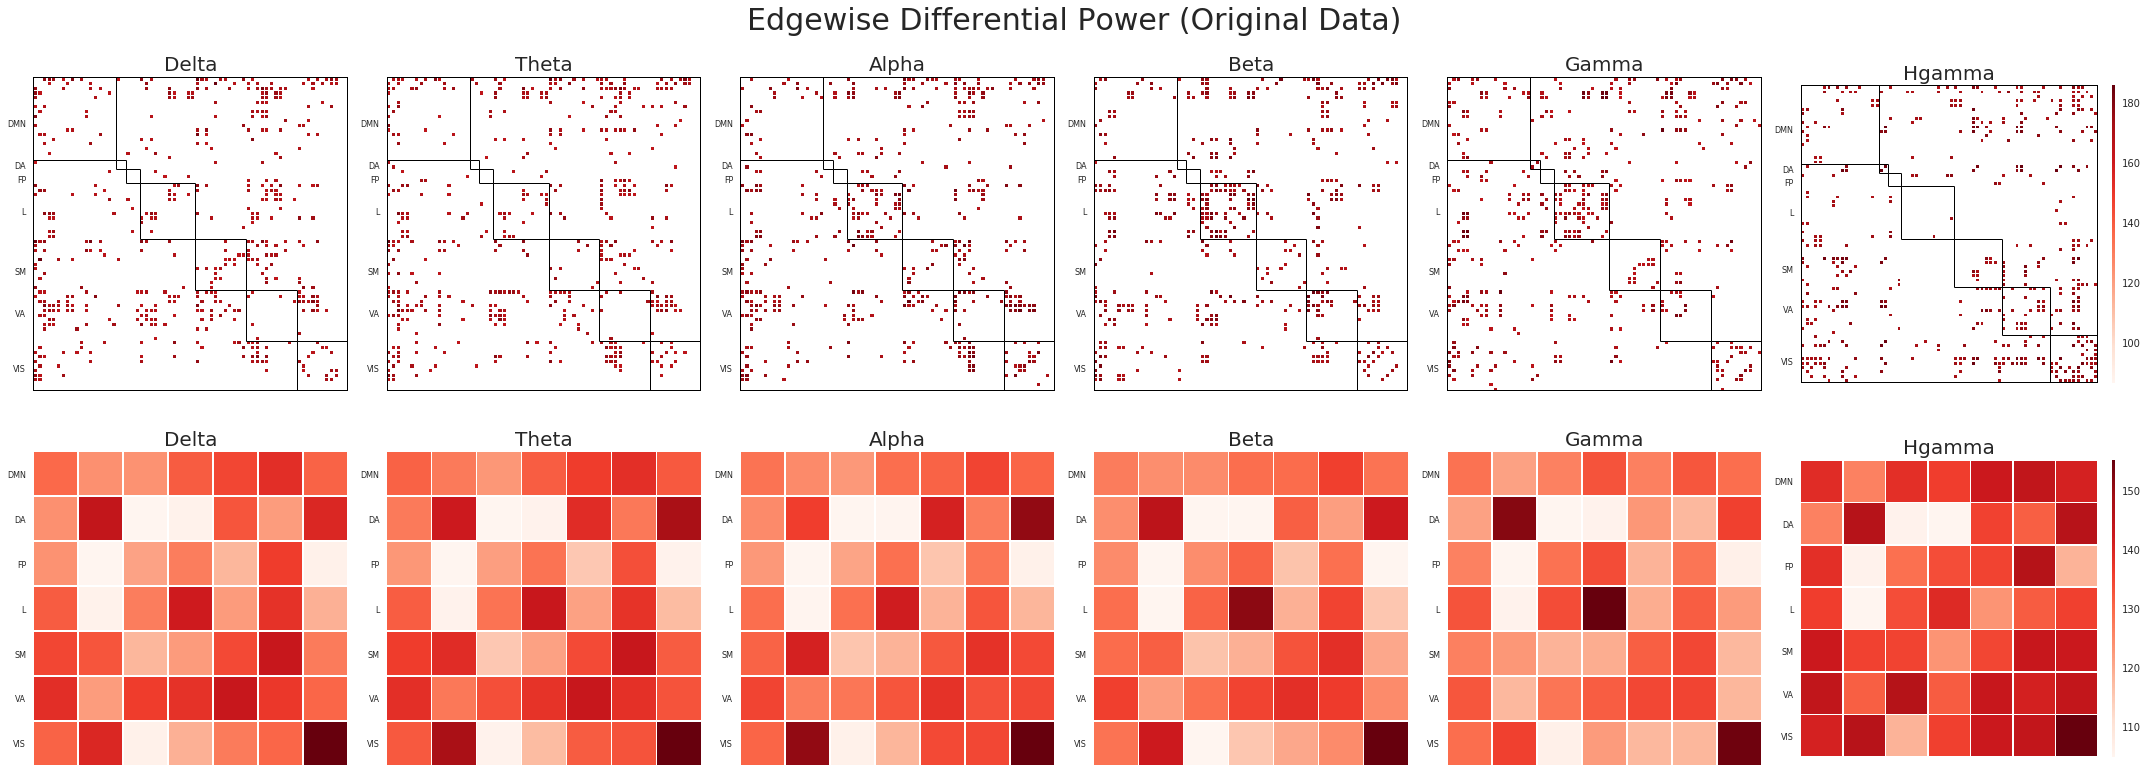

In [34]:
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
fig, axs = plt.subplots(2,6, figsize=(30, 30))
axs = axs.ravel()
frequency_edges = np.zeros((68, 68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency & get nth percentile value
    dp_df_freq = dp_df.loc[dp_df['freq'] == freq_band[i]]
    ordered_values = np.sort(dp_df_freq['differential_power'].values)[::-1]
    limit = np.floor((ordered_values.shape[0]) * .1).astype(int) # CHANGE HERE FOR PERCENTILE!
    percentile_value = ordered_values[limit]
    dp_df_freq = dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(dp_df_freq.values))
    dp_df_freq.values[nan_location] = dp_df_freq.values[nan_location[1], nan_location[0]]
    
    # Arrange matrix based on node strength
    dp_df_freq['dp_node_str'] = dp_node_str
    temp_row = dp_df_freq.reset_index().sort_values(['rsn_srce','dp_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
    dp_df_freq_plot = temp_row[temp_row.index.tolist()]

    # Set diagonal to zero to bring out patterns
    np.fill_diagonal(dp_df_freq_plot.values, 0)
    
    # Get values for last plot
    frequency_edges[:, :, i] = (dp_df_freq_plot.values >= percentile_value).astype(float)
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(dp_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = min_dp, ax = axs[i], cbar_ax = cax,
                xticklabels= False, yticklabels = False, mask = (dp_df_freq_plot < percentile_value))
        
    else:    
        sns.heatmap(dp_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = min_dp, ax = axs[i], cbar = False, 
                xticklabels= False, yticklabels = False, mask = (dp_df_freq_plot < percentile_value))
    axs[i].hlines([0, 68], 68, 0, linewidth = 2)
    axs[i].vlines([0, 68], 68, 0, linewidth = 2)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i].set_yticks([10, 19, 22, 29, 42, 51, 63])
    axs[i].yaxis.set_tick_params(labelsize=8)
    axs[i].set_title(freq_band[i].title(), size = 20)
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')

# We do the same to get the differential power at the RSN level
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    dp_df_freq = dp_df.loc[dp_df['freq'] == freq_band[i]]
    dp_df_freq = dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(dp_df_freq.values))
    dp_df_freq.values[nan_location] = dp_df_freq.values[nan_location[1], nan_location[0]]
    dp_df_rsn = dp_df_freq.mean(level= 'rsn_srce').transpose().mean(level= 'rsn_trgt').transpose()
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i + 6])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(dp_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar_ax = cax,
                xticklabels= False, yticklabels = False)
    else: 
        sns.heatmap(dp_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar = False, 
                xticklabels= False, yticklabels = False)
    axs[i + 6].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i + 6].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    axs[i + 6].yaxis.set_tick_params(labelsize=8)
    axs[i + 6].set_title(freq_band[i].title(), size = 20)
    axs[i + 6].set_ylabel('')    
    axs[i + 6].set_xlabel('')
plt.tight_layout()
plt.subplots_adjust(top = .45)
plt.suptitle('Edgewise Differential Power (Original Data)', y=0.42, size = 30)
plt.show()

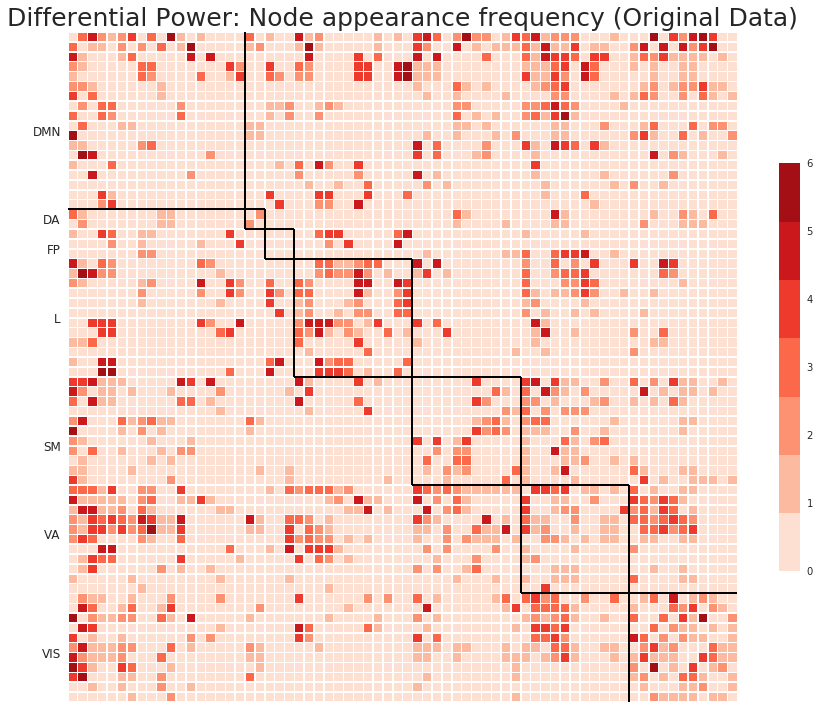

In [35]:
# Get 'any' existing data frame to plot the frequency distribution of edgewise nodes
pd_frequency_edges = dp_df.loc[dp_df['freq'] == 'alpha']
pd_frequency_edges = pd_frequency_edges.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='differential_power')

# Arrange matrix based on node strength (based on DP)
pd_frequency_edges['dp_node_str'] = dp_node_str
temp_row = pd_frequency_edges.reset_index().sort_values(['rsn_srce','dp_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
pd_frequency_edges_plot = temp_row[temp_row.index.tolist()]

# Get the frequency values
pd_frequency_edges_plot.values[:, :] = frequency_edges.sum(axis = 2).astype(int)

# Set diagonal to zero to bring out patterns
np.fill_diagonal(pd_frequency_edges_plot.values, 0)

# Draw the full plot
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(pd_frequency_edges_plot, square=True, linewidths=.5, 
            xticklabels= False, yticklabels = False, ax = ax, cbar_kws = {'shrink': 0.5}, cmap = sns.color_palette("Reds", 7))
ax.hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
ax.set_yticks([10, 19, 22, 29, 42, 51, 63])
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title('Differential Power: Node appearance frequency (Original Data)', size = 25)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

## Differential Power: Reconstructed Data

In [36]:
# Calculate the node strength to order graphs based on this 
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
means = np.zeros((68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    pca_dp_df_freq = pca_dp_df.loc[pca_dp_df['freq'] == freq_band[i]]
    pca_dp_df_freq = pca_dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_dp_df_freq.values))
    pca_dp_df_freq.values[nan_location] = pca_dp_df_freq.values[nan_location[1], nan_location[0]]
    
    # Create a mean column to order nodes based on node strength
    means[:, i] = pca_dp_df_freq.as_matrix().mean(axis = 1)
    
pca_dp_node_str = means.mean(axis = 1)

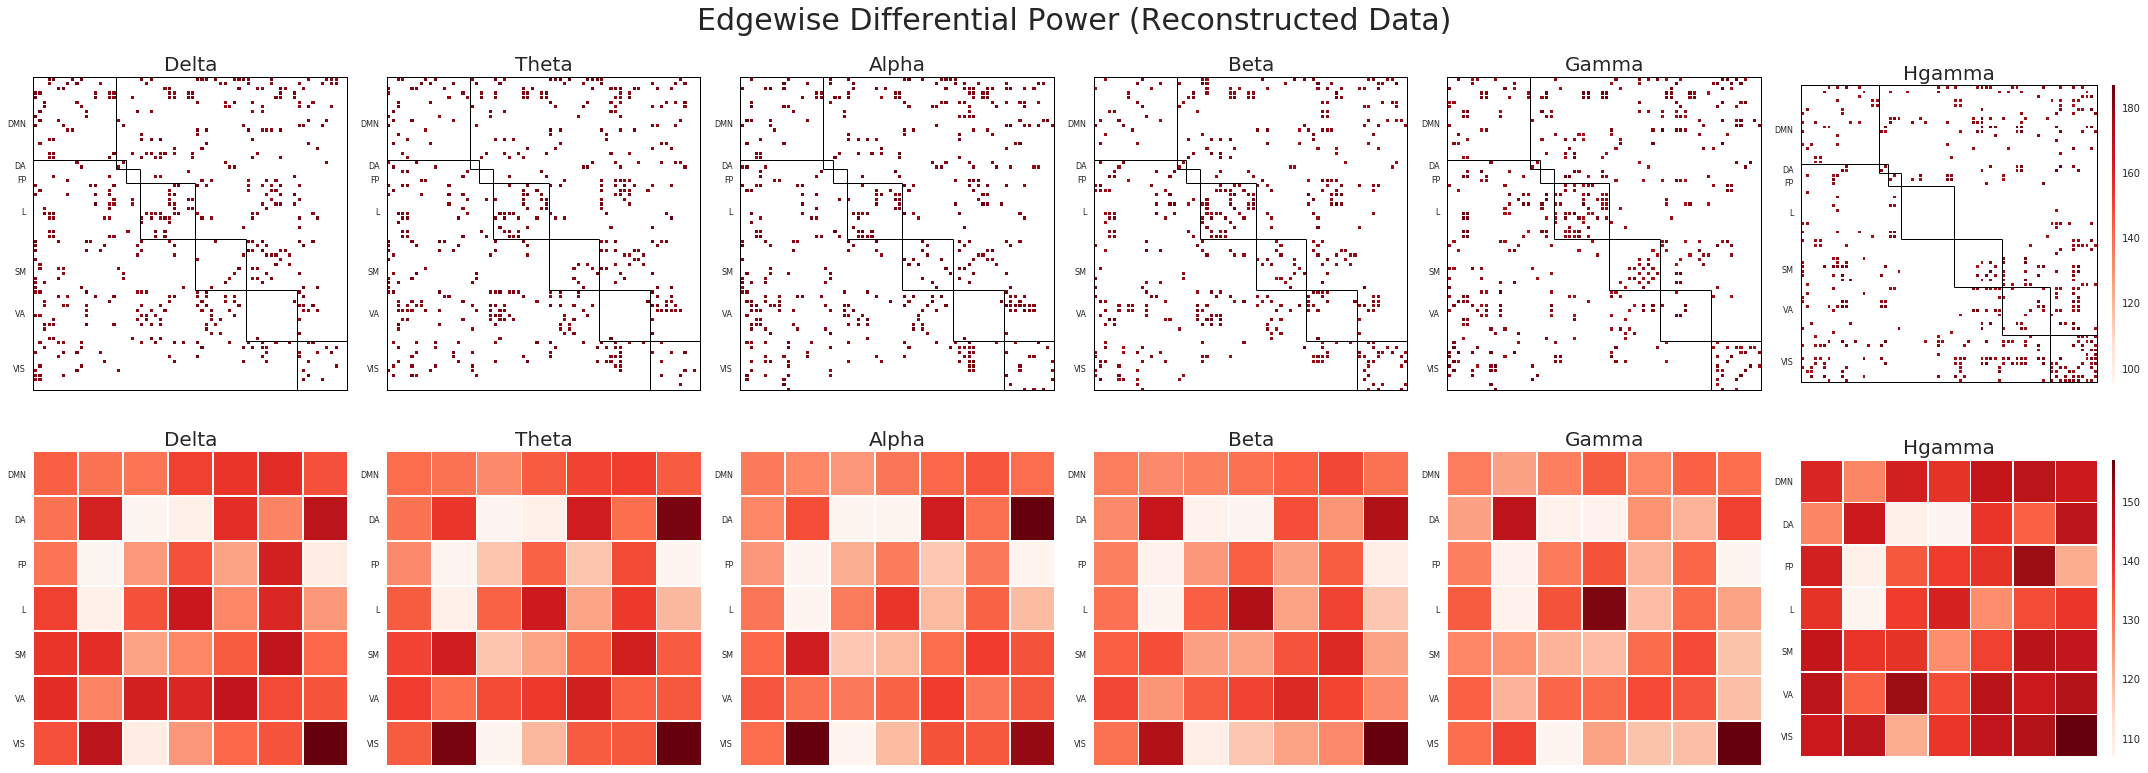

In [37]:
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
fig, axs = plt.subplots(2,6, figsize=(30, 30))
axs = axs.ravel()
pca_frequency_edges = np.zeros((68, 68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency & get nth percentile value
    pca_dp_df_freq = pca_dp_df.loc[pca_dp_df['freq'] == freq_band[i]]
    ordered_values = np.sort(pca_dp_df_freq['pca_differential_power'].values)[::-1]
    limit = np.floor((ordered_values.shape[0]) * .1).astype(int) # CHANGE HERE FOR PERCENTILE!
    percentile_value = ordered_values[limit]
    pca_dp_df_freq = pca_dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_dp_df_freq.values))
    pca_dp_df_freq.values[nan_location] = pca_dp_df_freq.values[nan_location[1], nan_location[0]]
    
    # Arrange matrix based on node strength
    pca_dp_df_freq['pca_dp_node_str'] = pca_dp_node_str
    temp_row = pca_dp_df_freq.reset_index().sort_values(['rsn_srce','pca_dp_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
    pca_dp_df_freq_plot = temp_row[temp_row.index.tolist()]

    # Set diagonal to zero to bring out patterns
    np.fill_diagonal(pca_dp_df_freq_plot.values, 0)
    
    # Get values for last plot
    pca_frequency_edges[:, :, i] = (pca_dp_df_freq_plot.values >= percentile_value).astype(float)
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(pca_dp_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = pca_min_dp, ax = axs[i], cbar_ax = cax,
                xticklabels= False, yticklabels = False, mask = (pca_dp_df_freq_plot < percentile_value))
        
    else:    
        sns.heatmap(pca_dp_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = pca_min_dp, ax = axs[i], cbar = False, 
                xticklabels= False, yticklabels = False, mask = (pca_dp_df_freq_plot < percentile_value))
    axs[i].hlines([0, 68], 68, 0, linewidth = 2)
    axs[i].vlines([0, 68], 68, 0, linewidth = 2)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i].set_yticks([10, 19, 22, 29, 42, 51, 63])
    axs[i].yaxis.set_tick_params(labelsize=8)
    axs[i].set_title(freq_band[i].title(), size = 20)
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')

# We do the same to get the differential power at the RSN level
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    pca_dp_df_freq = pca_dp_df.loc[pca_dp_df['freq'] == freq_band[i]]
    pca_dp_df_freq = pca_dp_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_differential_power')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_dp_df_freq.values))
    pca_dp_df_freq.values[nan_location] = pca_dp_df_freq.values[nan_location[1], nan_location[0]]
    pca_dp_df_rsn = pca_dp_df_freq.mean(level= 'rsn_srce').transpose().mean(level= 'rsn_trgt').transpose()
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i + 6])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(pca_dp_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar_ax = cax,
                xticklabels= False, yticklabels = False)
    else: 
        sns.heatmap(pca_dp_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar = False, 
                xticklabels= False, yticklabels = False)
    axs[i + 6].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i + 6].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    axs[i + 6].yaxis.set_tick_params(labelsize=8)
    axs[i + 6].set_title(freq_band[i].title(), size = 20)
    axs[i + 6].set_ylabel('')    
    axs[i + 6].set_xlabel('')
plt.tight_layout()
plt.subplots_adjust(top = .45)
plt.suptitle('Edgewise Differential Power (Reconstructed Data)', y=0.42, size = 30)
plt.show()

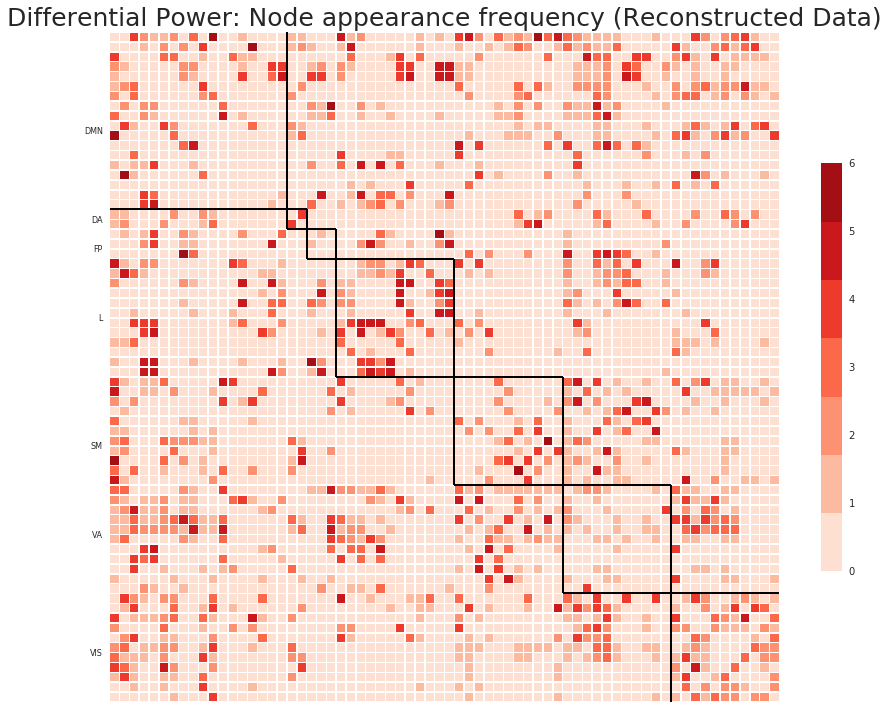

In [38]:
# Get 'any' existing data frame to plot the frequency distribution of edgewise nodes
pca_pd_frequency_edges = pca_dp_df.loc[pca_dp_df['freq'] == 'alpha']
pca_pd_frequency_edges = pca_pd_frequency_edges.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_differential_power')

# Arrange matrix based on node strength (based on DP)
pca_pd_frequency_edges['pca_dp_node_str'] = pca_dp_node_str
temp_row = pd_frequency_edges.reset_index().sort_values(['rsn_srce','dp_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
pca_pd_frequency_edges_plot = temp_row[temp_row.index.tolist()]

# Get the frequency values
pca_pd_frequency_edges_plot.values[:, :] = pca_frequency_edges.sum(axis = 2).astype(int)

# Set diagonal to zero to bring out patterns
np.fill_diagonal(pca_pd_frequency_edges_plot.values, 0)

# Draw the full plot
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(pca_pd_frequency_edges_plot, square=True, linewidths=.5, 
            xticklabels= False, yticklabels = False, ax = ax, cbar_kws = {'shrink': 0.5}, cmap = sns.color_palette("Reds", 7))
ax.hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
ax.set_yticks([10, 19, 22, 29, 42, 51, 63])
ax.yaxis.set_tick_params(labelsize=8)
ax.set_title('Differential Power: Node appearance frequency (Reconstructed Data)', size = 25)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

## Group Consistency: Original Data

In [39]:
# To get phi, we get mean across subjects of rho_ii (larger values of this indicate edges that are important for identification)
group_consistency = np.mean(z_target * z_database, axis = 0)
min_gc = np.min(group_consistency)
max_gc = np.max(group_consistency)

# Leverage all the things we've done to the differential power dataframe
gc_df = dp_df.rename(columns={'differential_power': 'group_consistency'})
gc_df['group_consistency'] = group_consistency.astype(float)
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']

# Get node strength to order graphs
means = np.zeros((68, 6))
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    gc_df_freq = gc_df.loc[gc_df['freq'] == freq_band[i]]
    gc_df_freq = gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(gc_df_freq.values))
    gc_df_freq.values[nan_location] = gc_df_freq.values[nan_location[1], nan_location[0]]
    
    # Create a mean column to order nodes based on node strength
    means[:, i] = gc_df_freq.as_matrix().mean(axis = 1)
    
gc_node_str = means.mean(axis = 1)

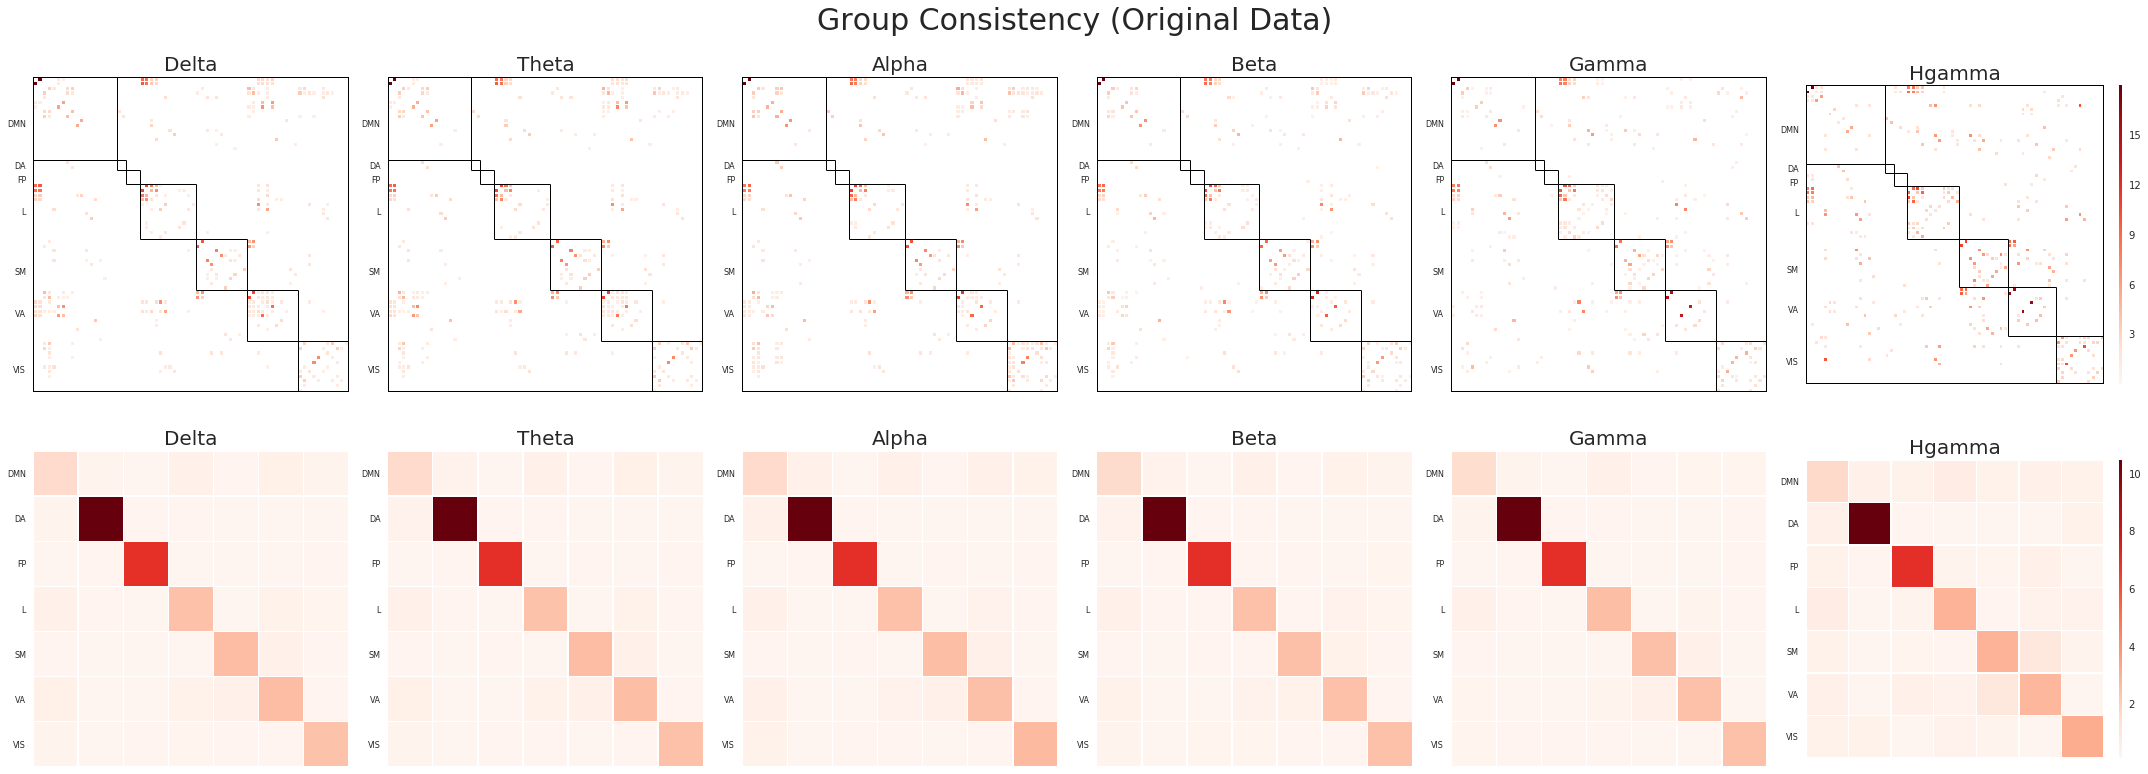

In [40]:
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
fig, axs = plt.subplots(2,6, figsize=(30, 30))
axs = axs.ravel()
frequency_edges = np.zeros((68, 68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency & get nth percentile value
    gc_df_freq = gc_df.loc[gc_df['freq'] == freq_band[i]]
    ordered_values = np.sort(gc_df_freq['group_consistency'].values)[::-1]
    limit = np.floor((ordered_values.shape[0]) * .1).astype(int) # CHANGE HERE FOR PERCENTILE!
    percentile_value = ordered_values[limit]
    gc_df_freq = gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(gc_df_freq.values))
    gc_df_freq.values[nan_location] = gc_df_freq.values[nan_location[1], nan_location[0]]
    
    # Arrange matrix based on node strength
    gc_df_freq['gc_node_str'] = gc_node_str
    temp_row = gc_df_freq.reset_index().sort_values(['rsn_srce','gc_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
    gc_df_freq_plot = temp_row[temp_row.index.tolist()]

    # Set diagonal to zero to bring out patterns
    np.fill_diagonal(gc_df_freq_plot.values, 0)
    
    # Get values for last plot
    frequency_edges[:, :, i] = (gc_df_freq_plot.values >= percentile_value).astype(float)
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(gc_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = min_gc, ax = axs[i], cbar_ax = cax,
                xticklabels= False, yticklabels = False, mask = (gc_df_freq_plot < percentile_value))
        
    else:    
        sns.heatmap(gc_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = min_gc, ax = axs[i], cbar = False, 
                xticklabels= False, yticklabels = False, mask = (gc_df_freq_plot < percentile_value))
    axs[i].hlines([0, 68], 68, 0, linewidth = 2)
    axs[i].vlines([0, 68], 68, 0, linewidth = 2)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i].set_yticks([10, 19, 22, 29, 42, 51, 63])
    axs[i].yaxis.set_tick_params(labelsize=8)
    axs[i].set_title(freq_band[i].title(), size = 20)
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')

# We do the same to get the differential power at the RSN level
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    gc_df_freq = gc_df.loc[gc_df['freq'] == freq_band[i]]
    gc_df_freq = gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(gc_df_freq.values))
    gc_df_freq.values[nan_location] = gc_df_freq.values[nan_location[1], nan_location[0]]
    gc_df_rsn = gc_df_freq.mean(level= 'rsn_srce').transpose().mean(level= 'rsn_trgt').transpose()
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i + 6])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(gc_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar_ax = cax,
                xticklabels= False, yticklabels = False)
    else: 
        sns.heatmap(gc_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar = False, 
                xticklabels= False, yticklabels = False)
    axs[i + 6].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i + 6].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    axs[i + 6].yaxis.set_tick_params(labelsize=8)
    axs[i + 6].set_title(freq_band[i].title(), size = 20)
    axs[i + 6].set_ylabel('')    
    axs[i + 6].set_xlabel('')
plt.tight_layout()
plt.subplots_adjust(top = .45)
plt.suptitle('Group Consistency (Original Data)', y=0.42, size = 30)
plt.show()

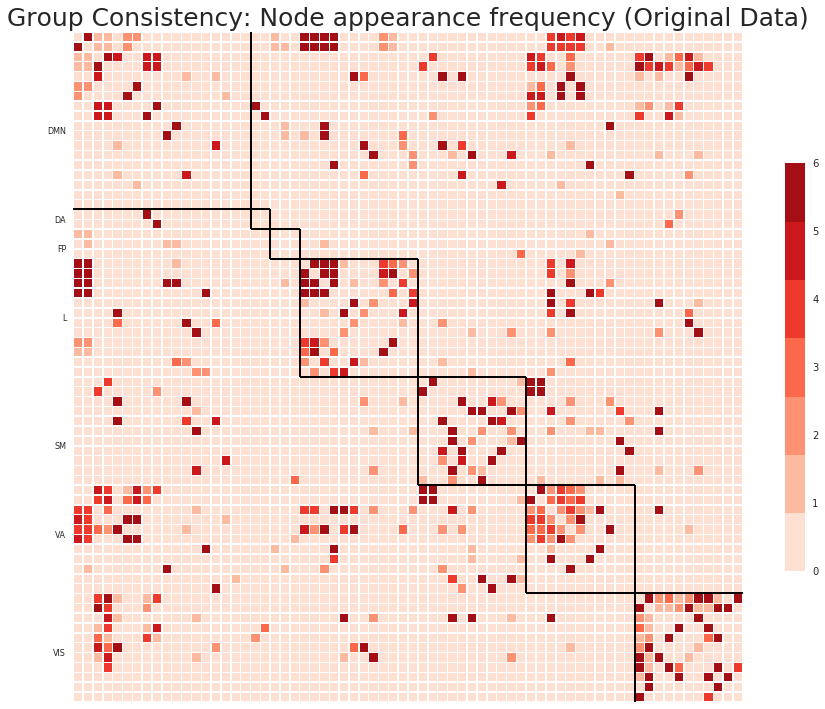

In [41]:
# Get 'any' existing data frame to plot the frequency distribution of edgewise nodes
gc_frequency_edges = gc_df.loc[gc_df['freq'] == 'alpha']
gc_frequency_edges = gc_frequency_edges.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='group_consistency')

# Arrange matrix based on node strength (based on GC)
gc_frequency_edges['gc_node_str'] = gc_node_str
temp_row = gc_frequency_edges.reset_index().sort_values(['rsn_srce','gc_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
gc_frequency_edges_plot = temp_row[temp_row.index.tolist()]

# Get the frequency values
gc_frequency_edges_plot.values[:, :] = frequency_edges.sum(axis = 2).astype(int)

# Set diagonal to zero to bring out patterns
np.fill_diagonal(gc_frequency_edges_plot.values, 0)

# Draw the full plot
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(gc_frequency_edges_plot, square=True, linewidths=.5, 
            xticklabels= False, yticklabels = False, ax = ax, cbar_kws = {'shrink': 0.5}, cmap = sns.color_palette("Reds", 7))
ax.hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
ax.set_yticks([10, 19, 22, 29, 42, 51, 63])
ax.yaxis.set_tick_params(labelsize=8)
ax.set_title('Group Consistency: Node appearance frequency (Original Data)', size = 25)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

## Group Consistency: Reconstructed Data

In [42]:
# To get phi, we get mean across subjects of rho_ii (larger values of this indicate edges that are important for identification)
pca_group_consistency = np.mean(pca_z_target * pca_z_database, axis = 0)
pca_min_gc = np.min(pca_group_consistency)
pca_max_gc = np.max(pca_group_consistency)

# Leverage all the things we've done to the differential power dataframe
pca_gc_df = dp_df.rename(columns={'differential_power': 'pca_group_consistency'})
pca_gc_df['pca_group_consistency'] = pca_group_consistency.astype(float)
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']

# Calculate the node strength to order graphes based on this 
means = np.zeros((68, 6))
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    pca_gc_df_freq = pca_gc_df.loc[pca_gc_df['freq'] == freq_band[i]]
    pca_gc_df_freq = pca_gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_gc_df_freq.values))
    pca_gc_df_freq.values[nan_location] = pca_gc_df_freq.values[nan_location[1], nan_location[0]]
    
    # Create a mean column to order nodes based on node strength
    means[:, i] = pca_gc_df_freq.as_matrix().mean(axis = 1)
    
pca_gc_node_str = means.mean(axis = 1)

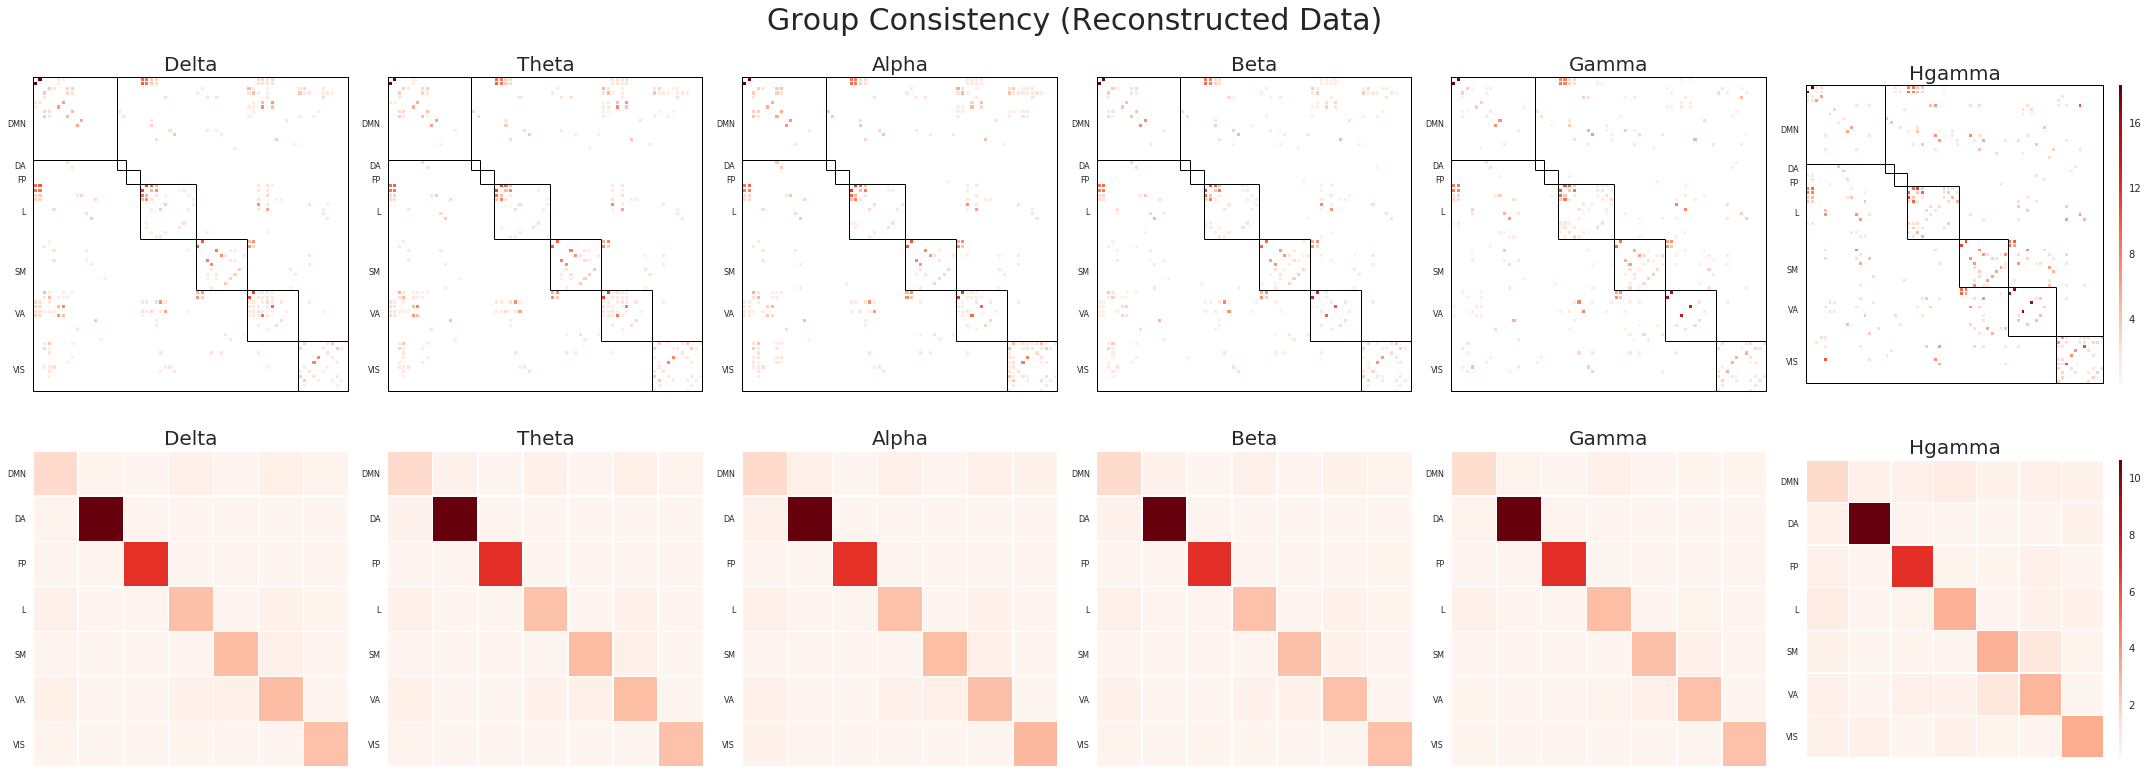

In [43]:
freq_band = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'hgamma']
fig, axs = plt.subplots(2,6, figsize=(30, 30))
axs = axs.ravel()
frequency_edges = np.zeros((68, 68, 6))

for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency & get nth percentile value
    pca_gc_df_freq = pca_gc_df.loc[pca_gc_df['freq'] == freq_band[i]]
    ordered_values = np.sort(pca_gc_df_freq['pca_group_consistency'].values)[::-1]
    limit = np.floor((ordered_values.shape[0]) * .1).astype(int) # CHANGE HERE FOR PERCENTILE!
    percentile_value = ordered_values[limit]
    pca_gc_df_freq = pca_gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_gc_df_freq.values))
    pca_gc_df_freq.values[nan_location] = pca_gc_df_freq.values[nan_location[1], nan_location[0]]
    
    # Arrange matrix based on node strength
    pca_gc_df_freq['pca_gc_node_str'] = pca_gc_node_str
    temp_row = pca_gc_df_freq.reset_index().sort_values(['rsn_srce','pca_gc_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
    pca_gc_df_freq_plot = temp_row[temp_row.index.tolist()]

    # Set diagonal to zero to bring out patterns
    np.fill_diagonal(pca_gc_df_freq_plot.values, 0)
    
    # Get values for last plot
    frequency_edges[:, :, i] = (pca_gc_df_freq_plot.values >= percentile_value).astype(float)
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(pca_gc_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = pca_min_gc, ax = axs[i], cbar_ax = cax,
                xticklabels= False, yticklabels = False, mask = (pca_gc_df_freq_plot < percentile_value))
        
    else:    
        sns.heatmap(pca_gc_df_freq_plot, cmap='Reds', square=True, linewidths=.5, 
                vmin = pca_min_gc, ax = axs[i], cbar = False, 
                xticklabels= False, yticklabels = False, mask = (pca_gc_df_freq_plot < percentile_value))
    axs[i].hlines([0, 68], 68, 0, linewidth = 2)
    axs[i].vlines([0, 68], 68, 0, linewidth = 2)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 1)
    axs[i].vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 1)
    axs[i].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i].set_yticks([10, 19, 22, 29, 42, 51, 63])
    axs[i].yaxis.set_tick_params(labelsize=8)
    axs[i].set_title(freq_band[i].title(), size = 20)
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')

# We do the same to get the differential power at the RSN level
for i in range(len(freq_band)):
    # Go from DataFrame to Matrix form for a given frequency
    pca_gc_df_freq = pca_gc_df.loc[pca_gc_df['freq'] == freq_band[i]]
    pca_gc_df_freq = pca_gc_df_freq.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_group_consistency')
    
    # Unfold the value matrix and substitute nan's
    nan_location = np.where(np.isnan(pca_gc_df_freq.values))
    pca_gc_df_freq.values[nan_location] = pca_gc_df_freq.values[nan_location[1], nan_location[0]]
    pca_gc_df_rsn = pca_gc_df_freq.mean(level= 'rsn_srce').transpose().mean(level= 'rsn_trgt').transpose()
    
    # Draw the full plot
    if i == (len(freq_band)-1):
        divider = make_axes_locatable(axs[i + 6])
        cax = divider.append_axes("right", size="1%", pad=0.2)
        sns.heatmap(pca_gc_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar_ax = cax,
                xticklabels= False, yticklabels = False)
    else: 
        sns.heatmap(pca_gc_df_rsn, cmap='Reds', square=True, linewidths=.5, 
                ax = axs[i + 6], cbar = False, 
                xticklabels= False, yticklabels = False)
    axs[i + 6].set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
    axs[i + 6].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    axs[i + 6].yaxis.set_tick_params(labelsize=8)
    axs[i + 6].set_title(freq_band[i].title(), size = 20)
    axs[i + 6].set_ylabel('')    
    axs[i + 6].set_xlabel('')
plt.tight_layout()
plt.subplots_adjust(top = .45)
plt.suptitle('Group Consistency (Reconstructed Data)', y=0.42, size = 30)
plt.show()

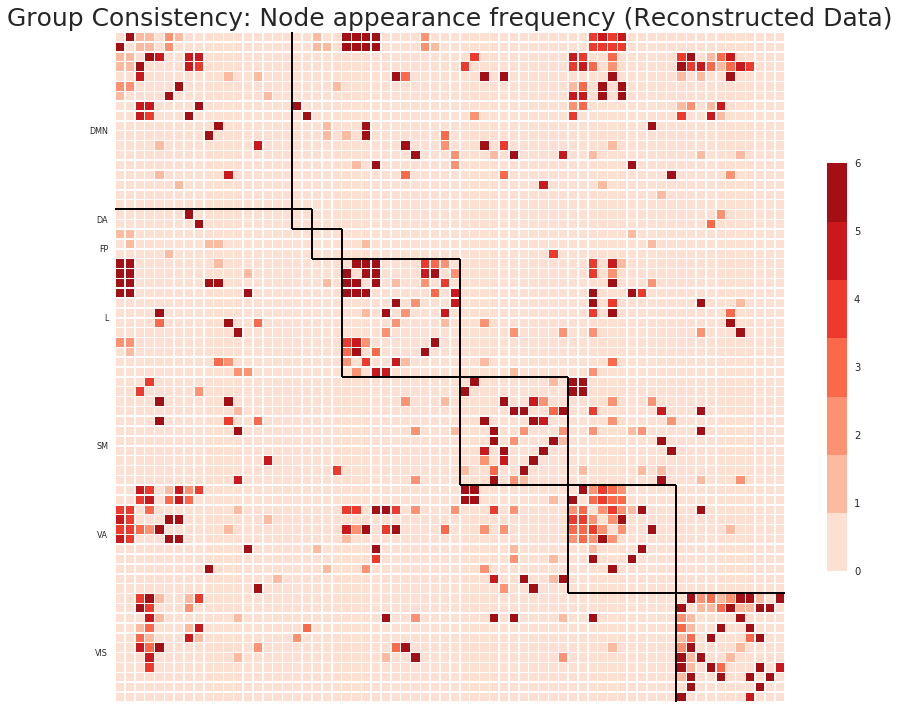

In [44]:
# Get 'any' existing data frame to plot the frequency distribution of edgewise nodes
pca_gc_frequency_edges = pca_gc_df.loc[pca_gc_df['freq'] == 'alpha']
pca_gc_frequency_edges = pca_gc_frequency_edges.pivot_table(index=['rsn_srce', 'source'], columns= ['rsn_trgt', 'target'], values='pca_group_consistency')

# Arrange matrix based on node strength (based on GC)
pca_gc_frequency_edges['pca_gc_node_str'] = pca_gc_node_str
temp_row = pca_gc_frequency_edges.reset_index().sort_values(['rsn_srce','pca_gc_node_str'], ascending=[True,False]).set_index(['rsn_srce','source'])
pca_gc_frequency_edges_plot = temp_row[temp_row.index.tolist()]

# Get the frequency values
pca_gc_frequency_edges_plot.values[:, :] = frequency_edges.sum(axis = 2).astype(int)

# Set diagonal to zero to bring out patterns
np.fill_diagonal(pca_gc_frequency_edges_plot.values, 0)

# Draw the full plot
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(pca_gc_frequency_edges_plot, square=True, linewidths=.5, 
            xticklabels= False, yticklabels = False, ax = ax, cbar_kws = {'shrink': 0.5}, cmap = sns.color_palette("Reds", 7))
ax.hlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.hlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [18, 20, 23, 35, 46, 57], [0, 18, 20, 23, 35, 46], linewidth = 2)
ax.vlines([18, 20, 23, 35, 46, 57], [20, 23, 35, 46, 57, 68], [18, 20, 23, 35, 46, 57], linewidth = 2)
ax.set_yticklabels(['DMN', 'DA', 'FP', 'L', 'SM', 'VA', 'VIS'])
ax.set_yticks([10, 19, 22, 29, 42, 51, 63])
ax.yaxis.set_tick_params(labelsize=8)
ax.set_title('Group Consistency: Node appearance frequency (Reconstructed Data)', size = 25)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

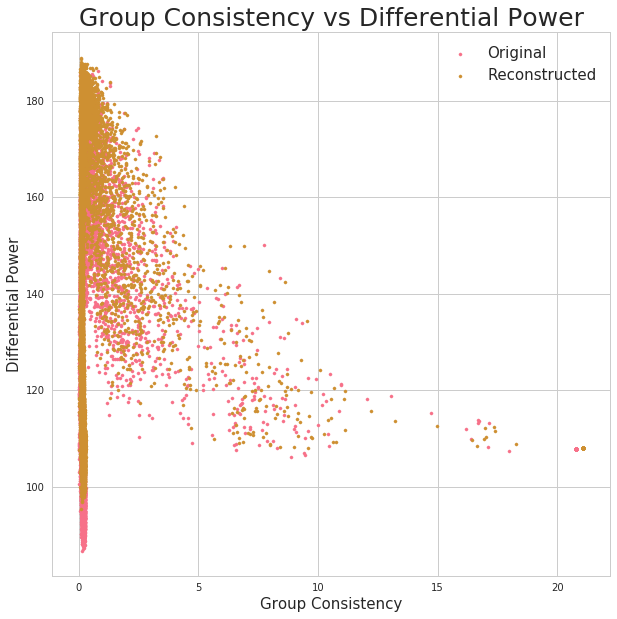

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(group_consistency, differential_power, label = 'Original', s = 10)
ax.scatter(pca_group_consistency, pca_differential_power, label = 'Reconstructed', s = 10)
ax.set_title('Group Consistency vs Differential Power', size = 25)
ax.set_xlabel('Group Consistency', fontsize = 15)
ax.set_ylabel('Differential Power', fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

# III. Relationship between identifiability and structural connectivity

In [214]:
# We first get the csv with the information regarding the average structural connections
anat_bool = sio.loadmat('dependencies/lau_sc_scale33.mat')['group_sc'].astype(int)
anat_df = pd.read_csv('dependencies/desikan_killiany_names.csv', names = ['name', 'region'])
anat_df = anat_df[anat_df['region'].values == "'cortical'"]
anat_df['temp'] = 0
anat_df['new_name_x'] = list(map(lambda x: x[4:-1] + x[1].upper(), anat_df['name'].values))
anat_df['new_name_y'] = list(map(lambda x: x[4:-1] + x[1].upper(), anat_df['name'].values))
anat_df.sort_values('new_name_x')
anat_df.sort_values('new_name_y')
anat_df = anat_df.pivot_table(index= 'new_name_x', columns= 'new_name_y', values = 'temp')
anat_df.values[:, :] = anat_bool
anat_df = anat_df.stack()
anat_df = anat_df[anat_df.index.get_level_values(0) <= anat_df.index.get_level_values(1)]
anat_df.index = anat_df.index.map('_'.join)
anat_df = np.concatenate((anat_df.values, anat_df.values, anat_df.values, anat_df.values, anat_df.values, anat_df.values))

# We create a grand structure dataset with all the variables of interest
structure_ind = dp_df
structure_ind['anatomy'] = anat_df
structure_ind['anatomy'] = structure_ind['anatomy'].astype('category')
structure_ind['freq'] = structure_ind['freq'].astype('category')
structure_ind['group_consistency'] = gc_df['group_consistency']
structure_ind['pca_differential_power'] = pca_dp_df['pca_differential_power']
structure_ind['pca_group_consistency'] = pca_gc_df['pca_group_consistency']

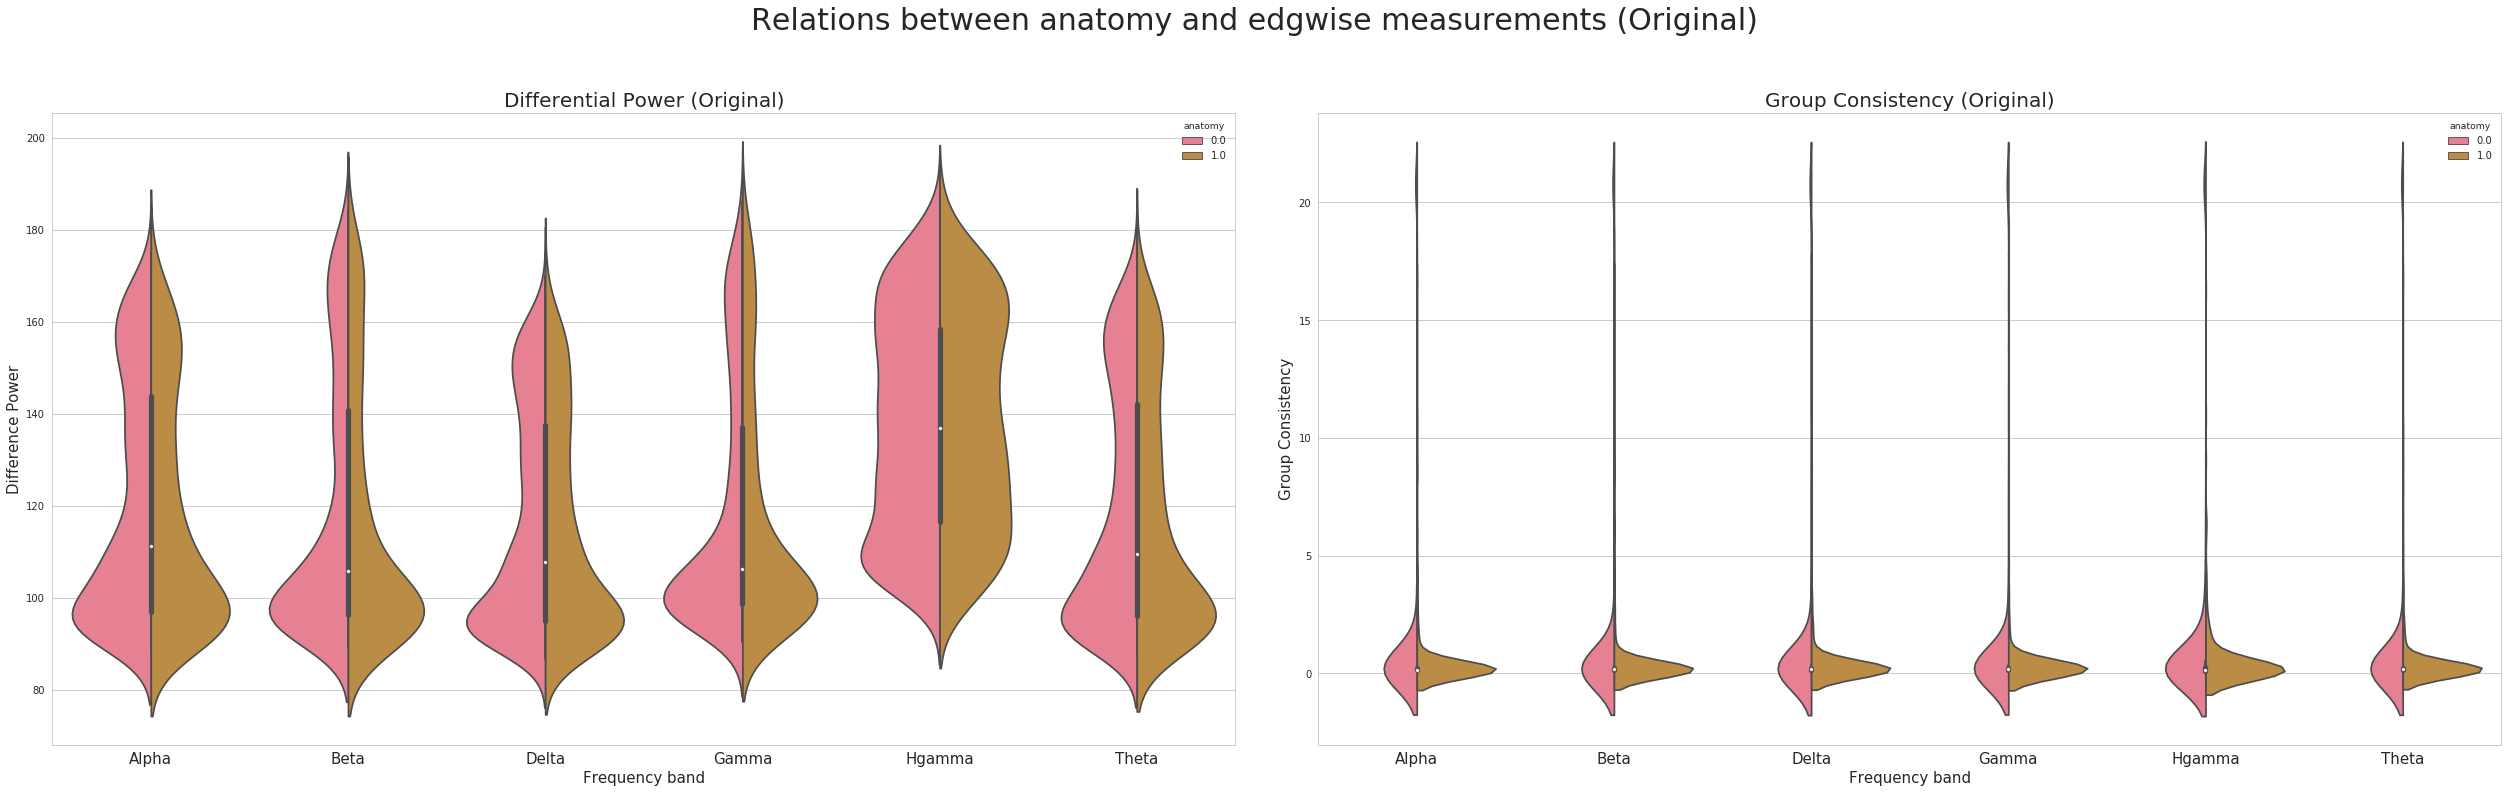

In [266]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,2, figsize=(35, 10))
axs = axs.ravel()

# Differential Power - Original
g = sns.violinplot(x = 'freq', y = 'differential_power', hue = 'anatomy', data = structure_ind, ax = axs[0], split=True)
axs[0].set_ylabel('Difference Power', fontsize = 15)
axs[0].set_xlabel('Frequency band', fontsize = 15)
axs[0].set_xticklabels(['Alpha', 'Beta', 'Delta', 'Gamma', 'Hgamma', 'Theta'], fontsize = 15)
axs[0].set_title('Differential Power (Original)', fontsize = 20)

# Group Consistency - Original
g = sns.violinplot(x = 'freq', y = 'group_consistency', hue = 'anatomy', data = structure_ind, ax = axs[1], split=True)
axs[1].set_ylabel('Group Consistency', fontsize = 15)
axs[1].set_xlabel('Frequency band', fontsize = 15)
axs[1].set_xticklabels(['Alpha', 'Beta', 'Delta', 'Gamma', 'Hgamma', 'Theta'], fontsize = 15)
axs[1].set_title('Group Consistency (Original)', fontsize = 20)

plt.suptitle('Relations between anatomy and edgwise measurements (Original)', y=1.1, size = 30)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.07)
plt.show()

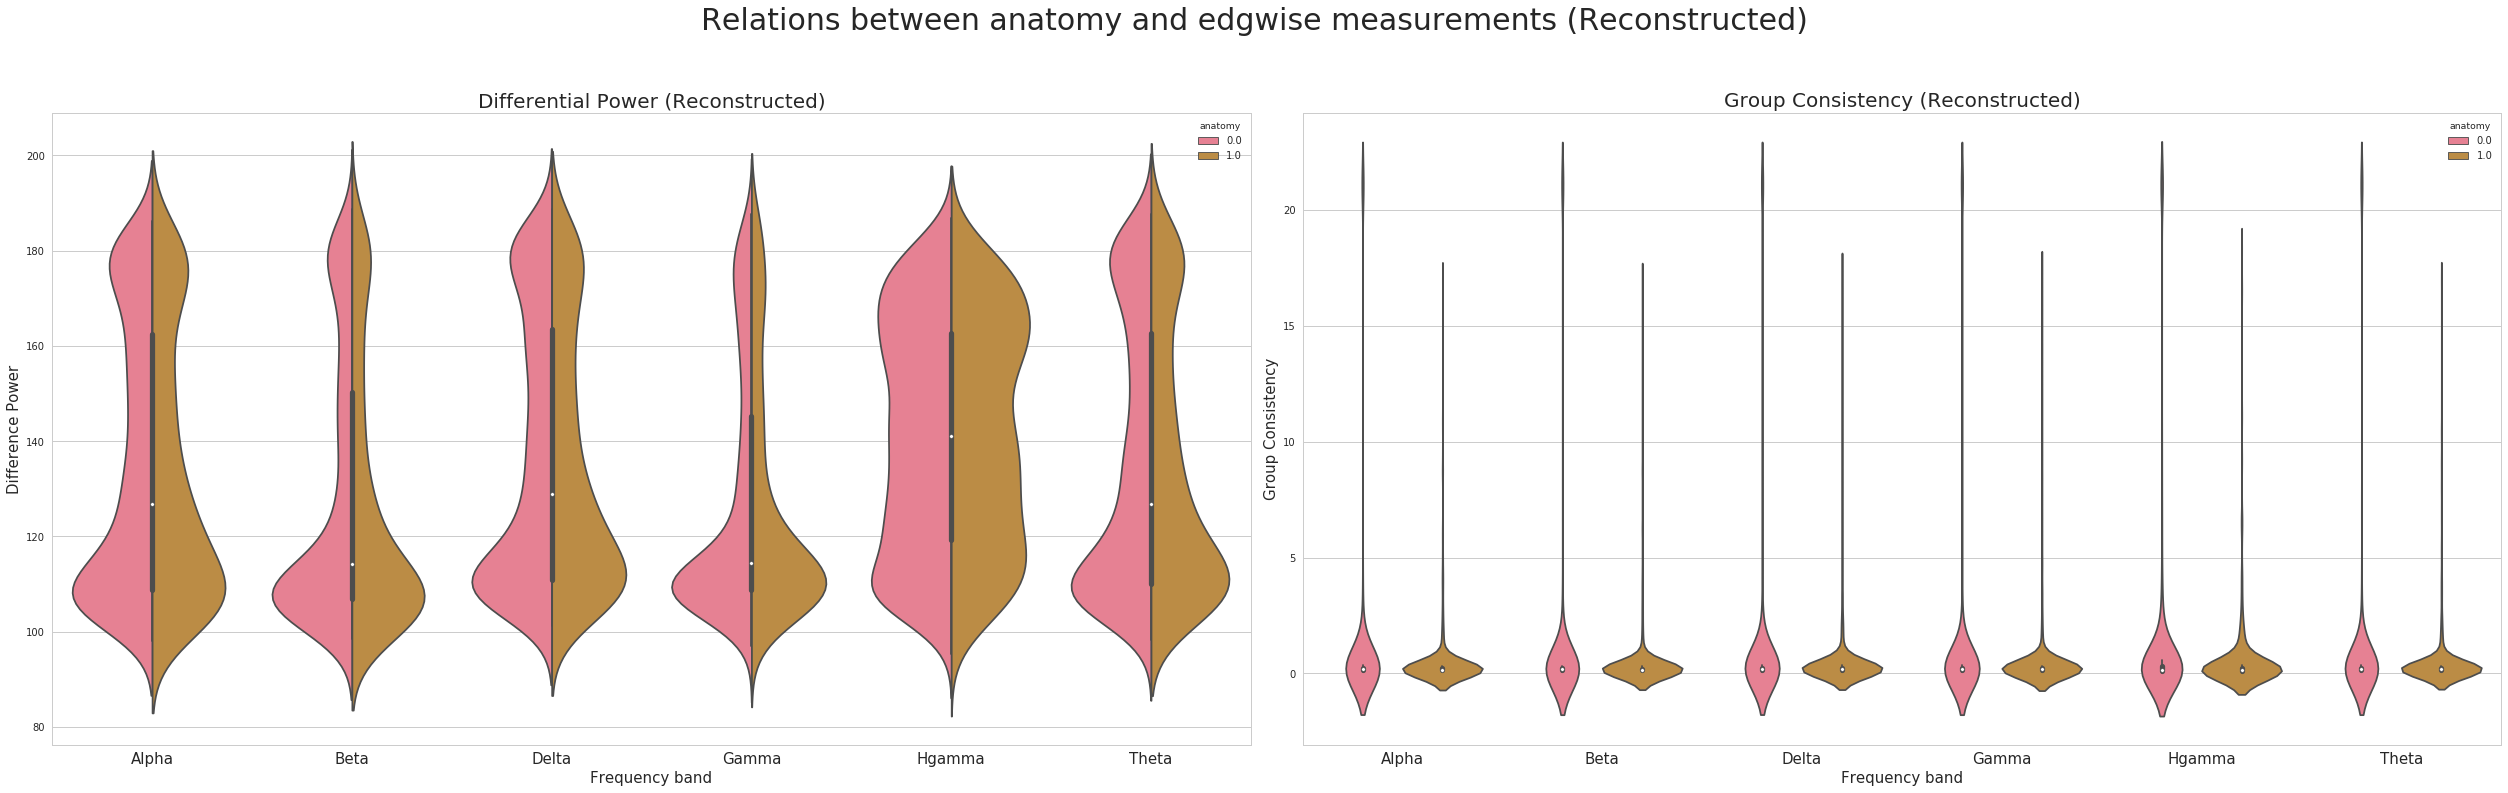

In [248]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,2, figsize=(35, 10))
axs = axs.ravel()

# Differential Power - Reconstructed
sns.violinplot(x = 'freq', y = 'pca_differential_power', hue = 'anatomy', data = structure_ind, ax = axs[0], split = True)
axs[0].set_ylabel('Difference Power', fontsize = 15)
axs[0].set_xlabel('Frequency band', fontsize = 15)
axs[0].set_xticklabels(['Alpha', 'Beta', 'Delta', 'Gamma', 'Hgamma', 'Theta'], fontsize = 15)
axs[0].set_title('Differential Power (Reconstructed)', fontsize = 20)

# Group Consistency - Reconstructed
sns.violinplot(x = 'freq', y = 'pca_group_consistency', hue = 'anatomy', data = structure_ind, ax = axs[1])
axs[1].set_ylabel('Group Consistency', fontsize = 15)
axs[1].set_xlabel('Frequency band', fontsize = 15)
axs[1].set_xticklabels(['Alpha', 'Beta', 'Delta', 'Gamma', 'Hgamma', 'Theta'], fontsize = 15)
axs[1].set_title('Group Consistency (Reconstructed)', fontsize = 20)

plt.suptitle('Relations between anatomy and edgwise measurements (Reconstructed)', y=1.1, size = 30)
plt.tight_layout()
plt.show()
plt.show()

# IV. Identifiability as a function of subjects' characteristics

In [290]:
# First we get subject number
def subs_list(sub):
    if sub < 10:
        return 'sub-000' + sub.astype(int).astype(str)
    elif sub >= 10 and sub < 100:
        return 'sub-00' + sub.astype(int).astype(str)
    else: 
        return 'sub-0' + sub.astype(int).astype(str)
    
# Get subject data from 
subs_analyzed = list(map(subs_list, sub_target[:, -1]))
subs_omega = pd.read_csv('data/OMEGA_BIDS/participants.tsv', sep='\t', header=0)
subs_omega = subs_omega[subs_omega['participants_id'].isin(subs_analyzed)]

# Wrangle data to get subjecs' age
sub_age = list(subs_omega['{session;age}'].values)
for x in range(len(sub_age)):
    if isinstance(sub_age[x], str):
        sub_age[x] = sub_age[x][3:5]
    else:
        sub_age[x] = np.nan
sub_age = np.array(sub_age).astype(float)
age_mean = np.floor(np.nanmean(sub_age))
inds = np.where(np.isnan(sub_age))
sub_age[inds] = age_mean
subs_omega['{session;age}'] = sub_age
subs_omega = subs_omega.rename(columns={'{session;age}': 'age'})

# Wrangle data to get subjects' group
sub_group = list(subs_omega['Group'].values)
for x in range(len(sub_group)):
    if isinstance(sub_group[x], str):
        if sub_group[x] != 'Control':
            sub_group[x] = 'Spec'
    else:
        sub_group[x] = 'Control' # The most common label here is 'Control', so I decided to handles NaN's that way
subs_omega['Group'] = sub_group

# Do some final wrangling before plotting relationshisp between variables and 
subs_omega['identifiability'] = self_id
subs_omega['pca_identifiability'] = pca_self_id
subs_omega = subs_omega.drop(['Year of birth', 'Questionnaire Version'], axis = 1)

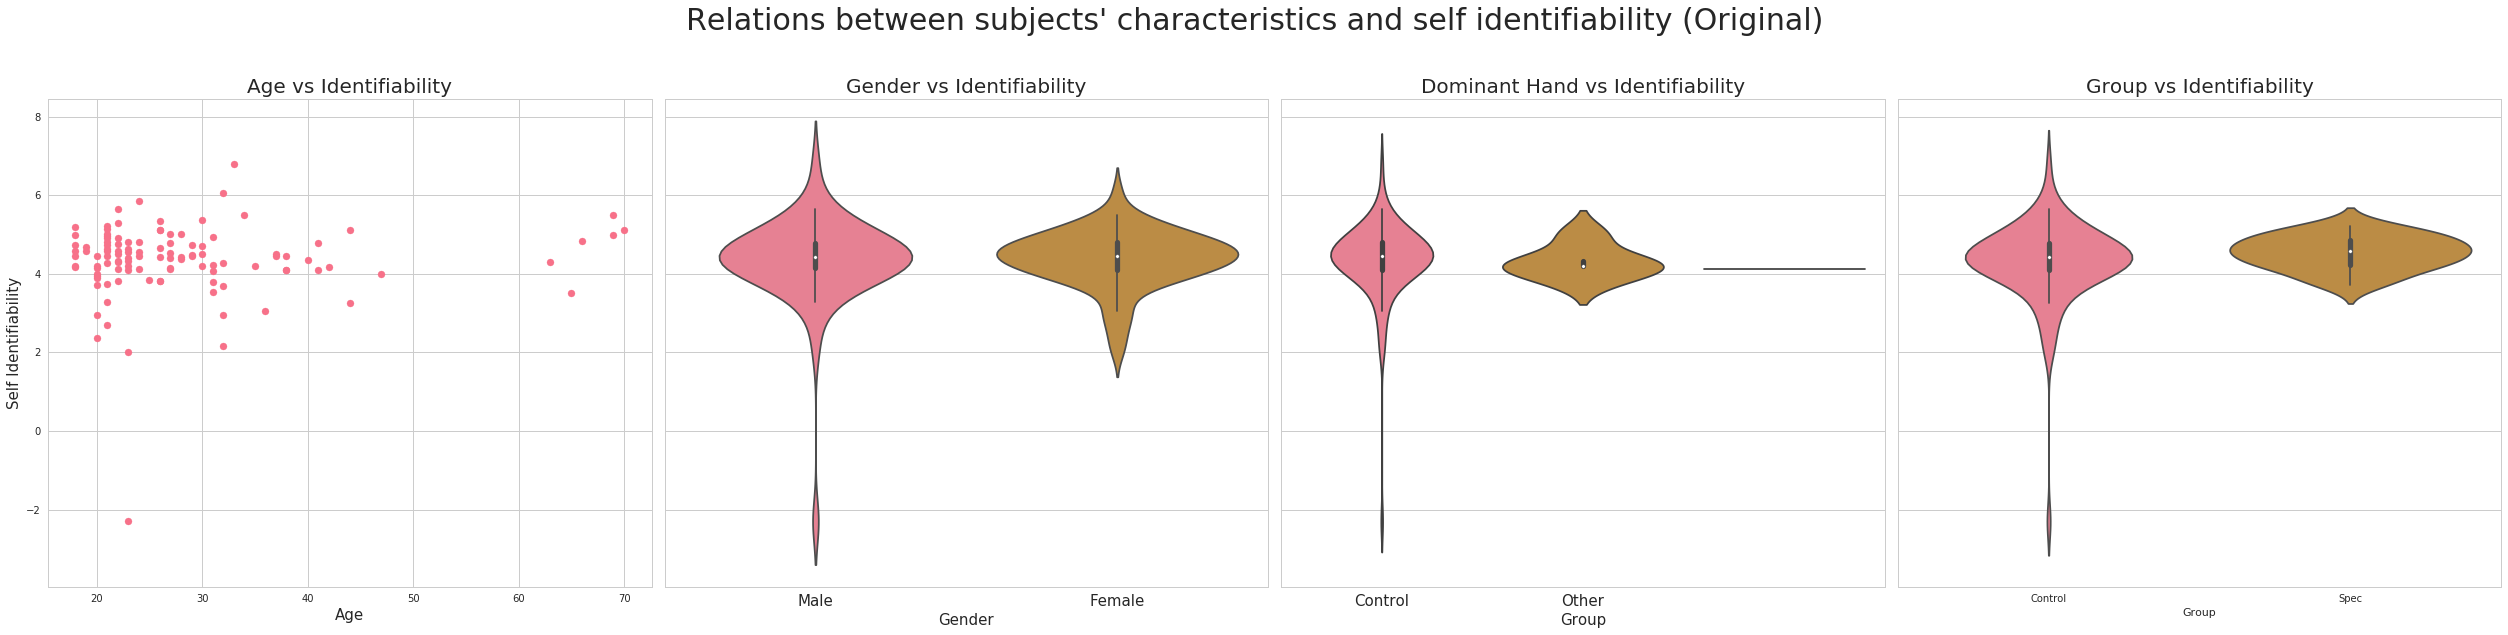

In [49]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,4, figsize=(35, 8), sharey=True)
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Age
axs[0].scatter(subs_omega['age'].values, subs_omega['identifiability'].values)    
axs[0].set_title('Age vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Age', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# Gender
sns.violinplot(x = 'Gender', y = 'identifiability', data = subs_omega, ax = axs[1])
axs[1].set_xlabel('Gender', fontsize = 15)
axs[1].set_xticklabels(['Male','Female'], fontsize = 15)
axs[1].set_ylabel('')
axs[1].set_title('Gender vs Identifiability', fontsize = 20)


# Dominant hand
sns.violinplot(x = 'Dominant Hand', y = 'identifiability', data = subs_omega, ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('Dominant Hand', fontsize = 15)
axs[2].set_xticklabels(['Right','Left', 'Other'], fontsize = 15)
axs[2].set_title('Dominant Hand vs Identifiability', fontsize = 20)

# Group
sns.violinplot(x = 'Group', y = 'identifiability', data = subs_omega, ax = axs[3])
axs[3].set_ylabel('')
axs[2].set_xlabel('Group', fontsize = 15)
axs[2].set_xticklabels(['Control','Other'], fontsize = 15)
axs[3].set_title('Group vs Identifiability', fontsize = 20)

plt.suptitle('Relations between subjects\' characteristics and self identifiability (Original)', y=1.1, size = 30)
plt.tight_layout()
plt.show()

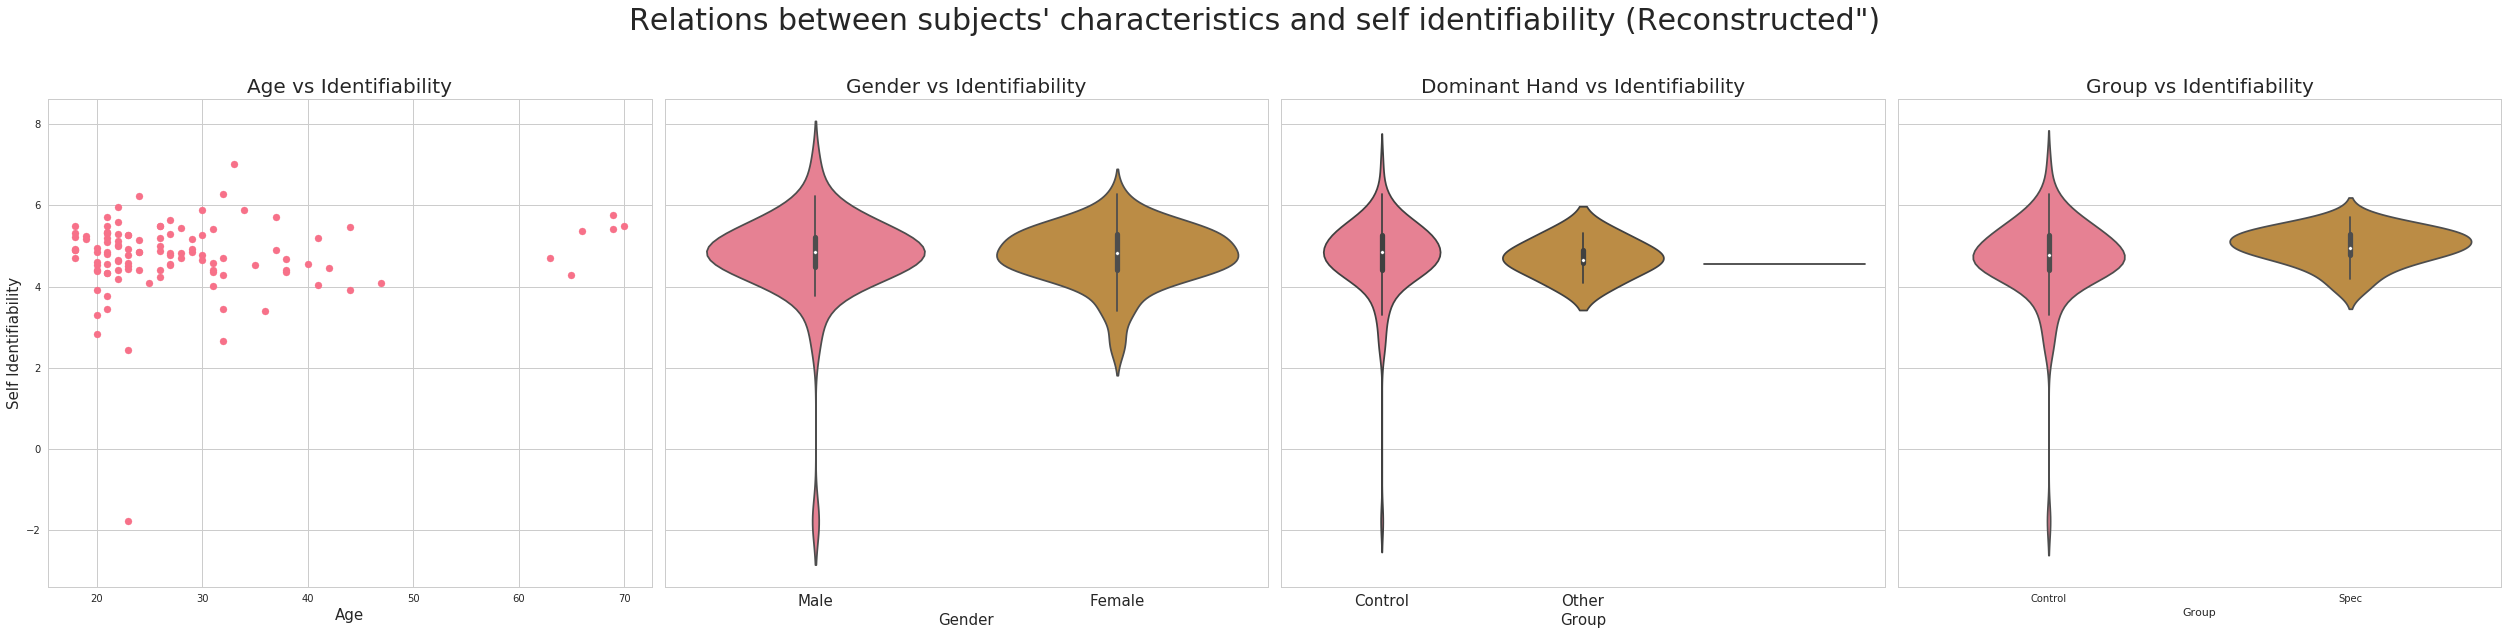

In [50]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,4, figsize=(35, 8), sharey=True)
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Age
axs[0].scatter(subs_omega['age'].values, subs_omega['pca_identifiability'].values)    
axs[0].set_title('Age vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Age', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# Gender
sns.violinplot(x = 'Gender', y = 'pca_identifiability', data = subs_omega, ax = axs[1])
axs[1].set_xlabel('Gender', fontsize = 15)
axs[1].set_xticklabels(['Male','Female'], fontsize = 15)
axs[1].set_ylabel('')
axs[1].set_title('Gender vs Identifiability', fontsize = 20)


# Dominant hand
sns.violinplot(x = 'Dominant Hand', y = 'pca_identifiability', data = subs_omega, ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('Dominant Hand', fontsize = 15)
axs[2].set_xticklabels(['Right','Left', 'Other'], fontsize = 15)
axs[2].set_title('Dominant Hand vs Identifiability', fontsize = 20)

# Group
sns.violinplot(x = 'Group', y = 'pca_identifiability', data = subs_omega, ax = axs[3])
axs[3].set_ylabel('')
axs[2].set_xlabel('Group', fontsize = 15)
axs[2].set_xticklabels(['Control','Other'], fontsize = 15)
axs[3].set_title('Group vs Identifiability', fontsize = 20)

plt.suptitle('Relations between subjects\' characteristics and self identifiability (Reconstructed")', y=1.1, size = 30)
plt.tight_layout()
plt.show()

# V. Sanity checks: Identifiability as a function of summary statistics for motion, cardiac activity, and eye movements

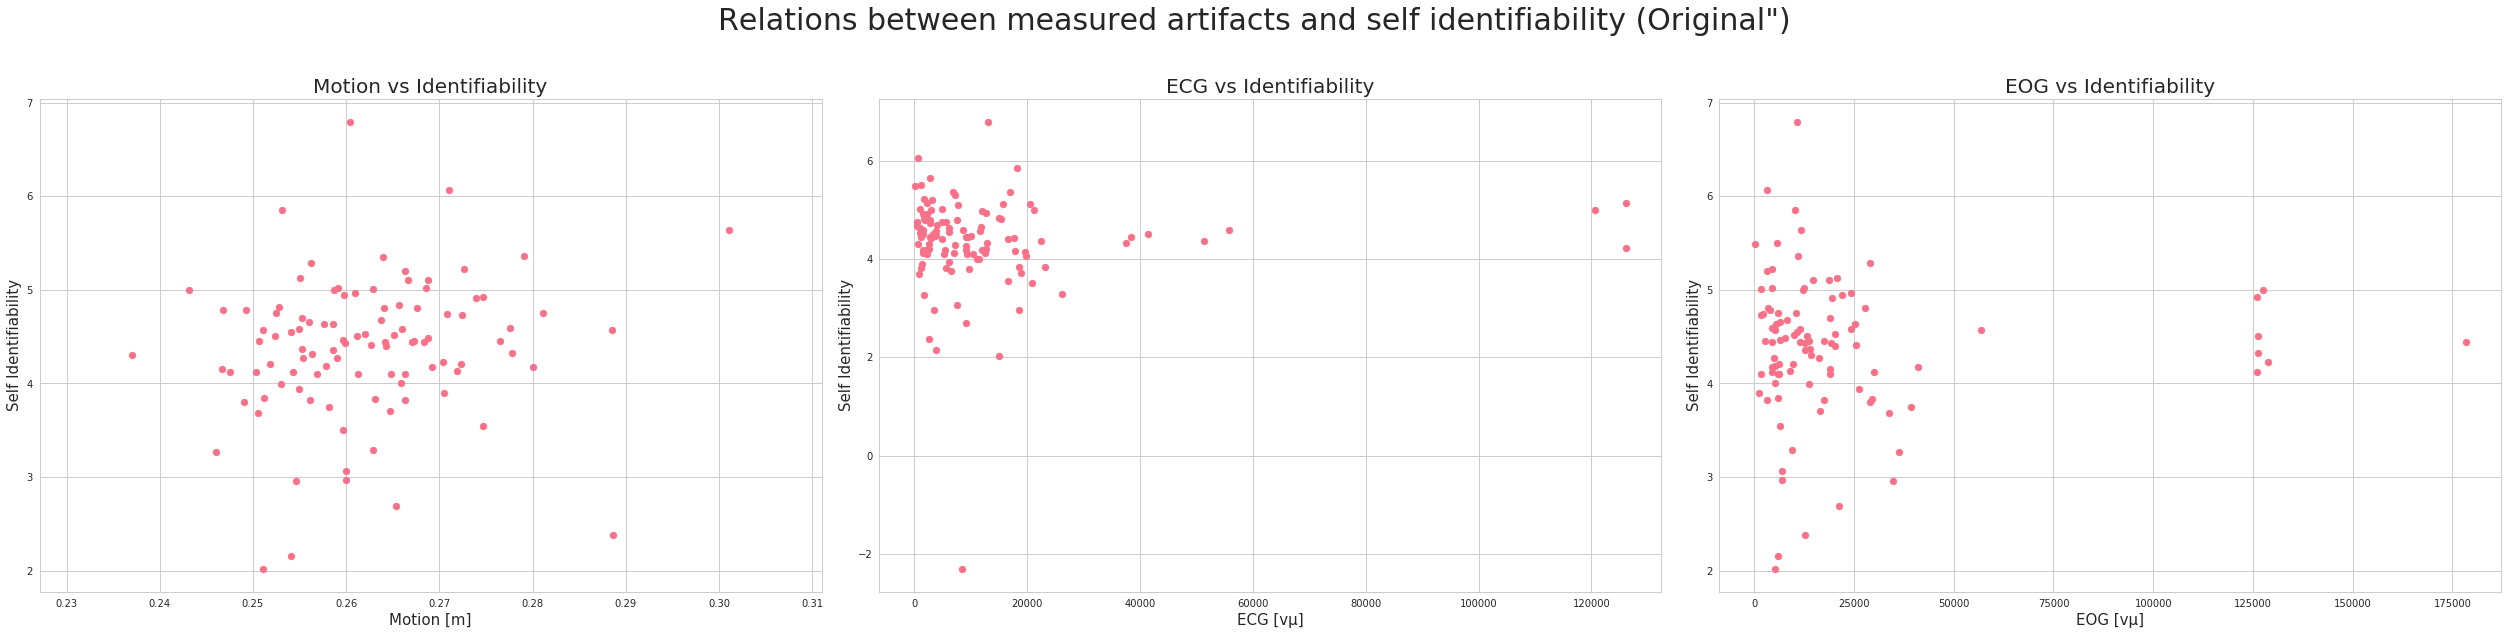

In [312]:
# First we get a big data frame
sanity_check = pd.read_csv('dependencies/eog_ecg_motion.csv')
sanity_check = sanity_check.head(n_subs)
sanity_check['self_id'] = self_id
sanity_check['pca_self_id'] = pca_self_id

# Plot relations between motion, ecg, eog -and- identifiability
fig, axs = plt.subplots(1,3, figsize=(35, 8))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Motion
axs[0].scatter(sanity_check['motion'].values, sanity_check['self_id'].values)    
axs[0].set_title('Motion vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Motion [m]', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# ECG
axs[1].scatter(sanity_check['ecg'].values, sanity_check['self_id'].values)    
axs[1].set_title('ECG vs Identifiability', fontsize = 20)
axs[1].set_xlabel('ECG [vµ]', fontsize = 15)
axs[1].set_ylabel('Self Identifiability', fontsize = 15)

# EOG
axs[2].scatter(sanity_check['eog'].values, sanity_check['self_id'].values)    
axs[2].set_title('EOG vs Identifiability', fontsize = 20)
axs[2].set_xlabel('EOG [vµ]', fontsize = 15)
axs[2].set_ylabel('Self Identifiability', fontsize = 15)

plt.suptitle('Relations between measured artifacts and self identifiability (Original")', y=1.1, size = 30)
plt.tight_layout()
plt.show()

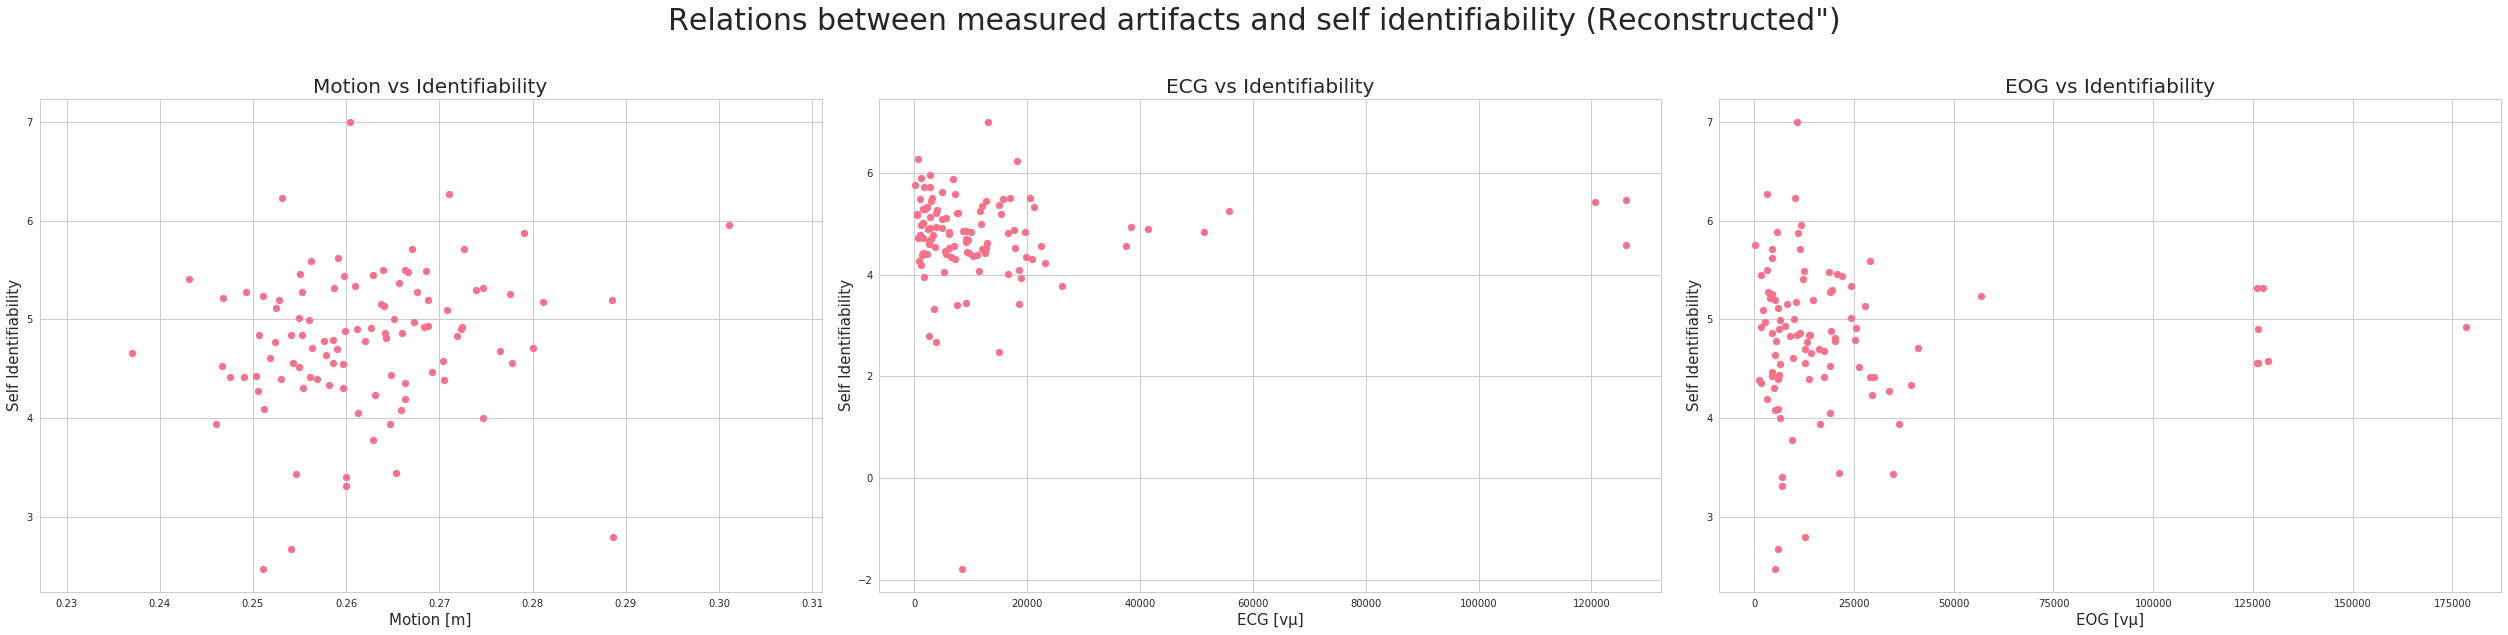

In [313]:
# Plot relations between motion, ecg, eog -and- identifiability
fig, axs = plt.subplots(1,3, figsize=(35, 8))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Motion
axs[0].scatter(sanity_check['motion'].values, sanity_check['pca_self_id'].values)    
axs[0].set_title('Motion vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Motion [m]', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# ECG
axs[1].scatter(sanity_check['ecg'].values, sanity_check['pca_self_id'].values)    
axs[1].set_title('ECG vs Identifiability', fontsize = 20)
axs[1].set_xlabel('ECG [vµ]', fontsize = 15)
axs[1].set_ylabel('Self Identifiability', fontsize = 15)

# EOG
axs[2].scatter(sanity_check['eog'].values, sanity_check['pca_self_id'].values)    
axs[2].set_title('EOG vs Identifiability', fontsize = 20)
axs[2].set_xlabel('EOG [vµ]', fontsize = 15)
axs[2].set_ylabel('Self Identifiability', fontsize = 15)

plt.suptitle('Relations between measured artifacts and self identifiability (Reconstructed")', y=1.1, size = 30)
plt.tight_layout()
plt.show()